# Breast Cancer Wisconsin (Diagnostic) — ML Project

**Corso:** Machine Learning — Universita' degli Studi di Milano-Bicocca  
**Dataset:** Breast Cancer Wisconsin (Diagnostic) — UCI ML Repository  
**Modelli:** SVM (Soft Margin, Kernel RBF) + Decision Tree (CART)  
**Autori:** Karzal Youness 879430, Marenghi Claudio 886178  
**Data:** febbraio 2026

## 1. Setup

In [40]:
!pip install pandas numpy matplotlib seaborn scikit-learn ucimlrepo

In [ ]:
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

---
## 2. Caricamento dataset

In [42]:
dataset = fetch_ucirepo(id=17)
X = dataset.data.features
y_raw = dataset.data.targets

le = LabelEncoder()
y = le.fit_transform(y_raw.iloc[:, 0])  # B=0, M=1

df = X.copy()
df['Diagnosis'] = y_raw.iloc[:, 0]
df['Diagnosis_num'] = y

print(f'Campioni: {X.shape[0]}')
print(f'Feature:  {X.shape[1]}')
print(f'Target:   {le.classes_} -> {le.transform(le.classes_)}')

Campioni: 569
Feature:  30
Target:   ['B' 'M'] -> [0 1]


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Qualita' dei Dati

In [43]:
missing = X.isnull().sum()
print(f'Missing values totali: {missing.sum()}')

print(f'Righe duplicate: {X.duplicated().sum()}')

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=[object]).columns.tolist()
print(f'Feature numeriche: {len(num_cols)}')
print(f'Feature categoriche: {len(cat_cols)}')

Missing values totali: 0
Righe duplicate: 0
Feature numeriche: 30
Feature categoriche: 0


### 3.2 Distribuzione del Target


Rapporto minoranza/maggioranza: 0.594
Imbalance moderato


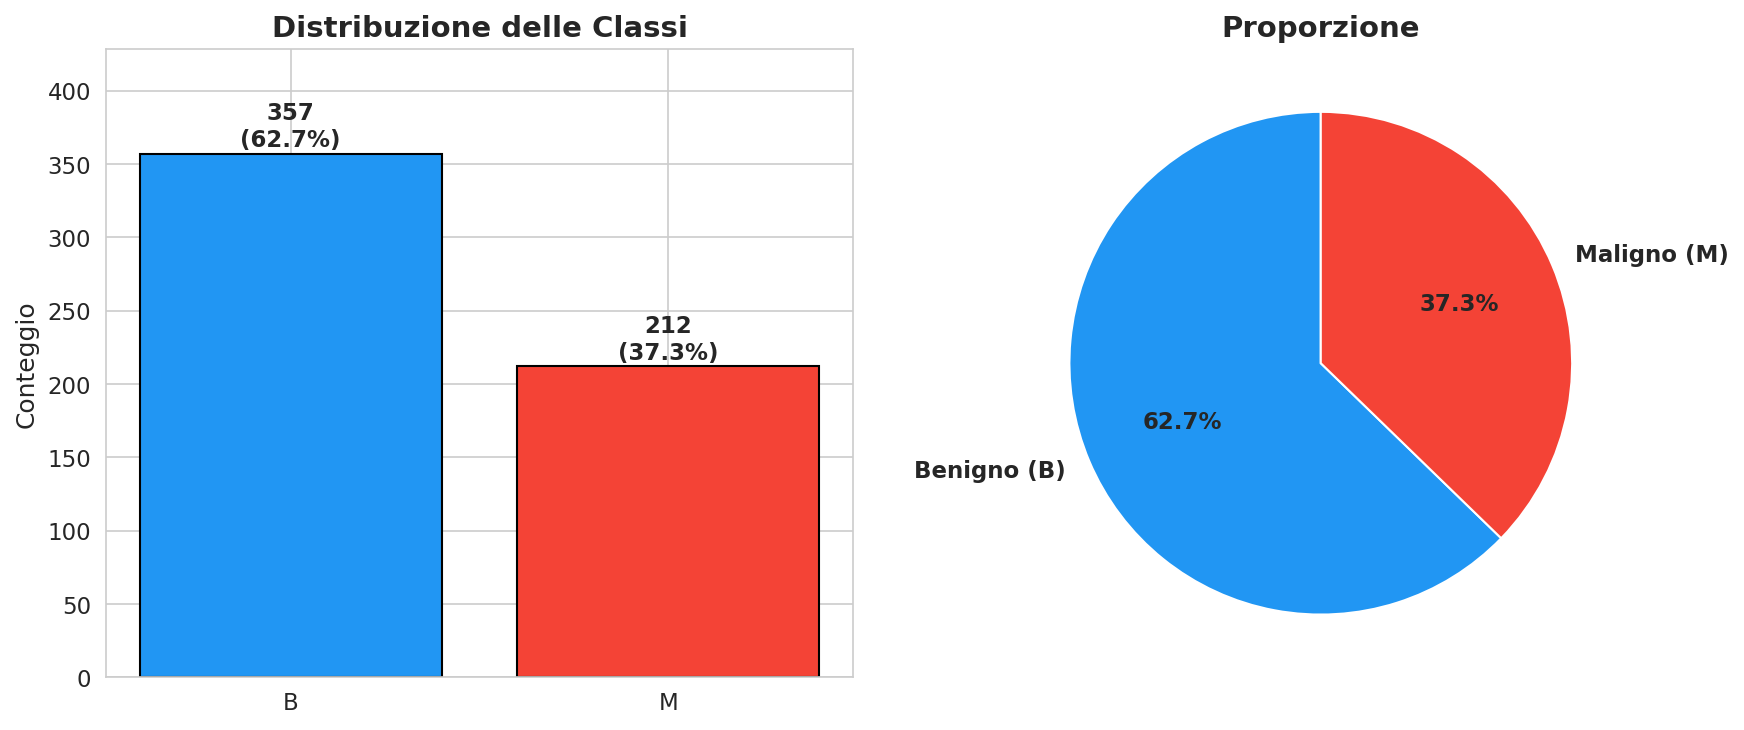

In [65]:
target_counts = df['Diagnosis'].value_counts()

ratio = target_counts.min() / target_counts.max()
print(f'\nRapporto minoranza/maggioranza: {ratio:.3f}')
print(f'Imbalance {"moderato" if ratio > 0.4 else "significativo"}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2196F3', '#F44336']
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribuzione delle Classi', fontweight='bold')
axes[0].set_ylabel('Conteggio')
axes[0].set_ylim(0, target_counts.max() * 1.2)
for i, (idx, val) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, val + 5, f'{val}\n({val/len(df)*100:.1f}%)', ha='center', fontweight='bold')

axes[1].pie(target_counts.values, labels=['Benigno (B)', 'Maligno (M)'],
            colors=colors, autopct='%1.1f%%', startangle=90,
            textprops={'fontweight': 'bold'})
axes[1].set_title('Proporzione', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.3 Statistiche Descrittive

In [45]:
stats = X.describe().T
display(stats.round(4))

count      mean       std       min       25%       50%  \
radius1             569.0   14.1273    3.5240    6.9810   11.7000   13.3700   
texture1            569.0   19.2896    4.3010    9.7100   16.1700   18.8400   
perimeter1          569.0   91.9690   24.2990   43.7900   75.1700   86.2400   
area1               569.0  654.8891  351.9141  143.5000  420.3000  551.1000   
smoothness1         569.0    0.0964    0.0141    0.0526    0.0864    0.0959   
compactness1        569.0    0.1043    0.0528    0.0194    0.0649    0.0926   
concavity1          569.0    0.0888    0.0797    0.0000    0.0296    0.0615   
concave_points1     569.0    0.0489    0.0388    0.0000    0.0203    0.0335   
symmetry1           569.0    0.1812    0.0274    0.1060    0.1619    0.1792   
fractal_dimension1  569.0    0.0628    0.0071    0.0500    0.0577    0.0615   
radius2             569.0    0.4052    0.2773    0.1115    0.2324    0.3242   
texture2            569.0    1.2169    0.5516    0.3602    0.8339    1.1080   
perimeter2          569.0    2.8661    2.0219    0.7570    1.6060    2.2870   
area2               569.0   40.3371   45.4910    6.8020   17.8500   24.5300   
smoothness2         569.0    0.0070    0.0030    0.0017    0.0052    0.0064   
compactness2        569.0    0.0255    0.0179    0.0023    0.0131    0.0204   
concavity2          569.0    0.0319    0.0302    0.0000    0.0151    0.0259   
concave_points2     569.0    0.0118    0.0062    0.0000    0.0076    0.0109   
symmetry2           569.0    0.0205    0.0083    0.0079    0.0152    0.0187   
fractal_dimension2  569.0    0.0038    0.0026    0.0009    0.0022    0.0032   
radius3             569.0   16.2692    4.8332    7.9300   13.0100   14.9700   
texture3            569.0   25.6772    6.1463   12.0200   21.0800   25.4100   
perimeter3          569.0  107.2612   33.6025   50.4100   84.1100   97.6600   
area3               569.0  880.5831  569.3570  185.2000  515.3000  686.5000   
smoothness3         569.0    0.1324    0.0228    0.0712    0.1166    0.1313   
compactness3        569.0    0.2543    0.1573    0.0273    0.1472    0.2119   
concavity3          569.0    0.2722    0.2086    0.0000    0.1145    0.2267   
concave_points3     569.0    0.1146    0.0657    0.0000    0.0649    0.0999   
symmetry3           569.0    0.2901    0.0619    0.1565    0.2504    0.2822   
fractal_dimension3  569.0    0.0839    0.0181    0.0550    0.0715    0.0800   

                          75%        max  
radius1               15.7800    28.1100  
texture1              21.8000    39.2800  
perimeter1           104.1000   188.5000  
area1                782.7000  2501.0000  
smoothness1            0.1053     0.1634  
compactness1           0.1304     0.3454  
concavity1             0.1307     0.4268  
concave_points1        0.0740     0.2012  
symmetry1              0.1957     0.3040  
fractal_dimension1     0.0661     0.0974  
radius2                0.4789     2.8730  
texture2               1.4740     4.8850  
perimeter2             3.3570    21.9800  
area2                 45.1900   542.2000  
smoothness2            0.0081     0.0311  
compactness2           0.0324     0.1354  
concavity2             0.0420     0.3960  
concave_points2        0.0147     0.0528  
symmetry2              0.0235     0.0790  
fractal_dimension2     0.0046     0.0298  
radius3               18.7900    36.0400  
texture3              29.7200    49.5400  
perimeter3           125.4000   251.2000  
area3               1084.0000  4254.0000  
smoothness3            0.1460     0.2226  
compactness3           0.3391     1.0580  
concavity3             0.3829     1.2520  
concave_points3        0.1614     0.2910  
symmetry3              0.3179     0.6638  
fractal_dimension3     0.0921     0.2075

### 3.4 Distribuzione delle Feature per Classe

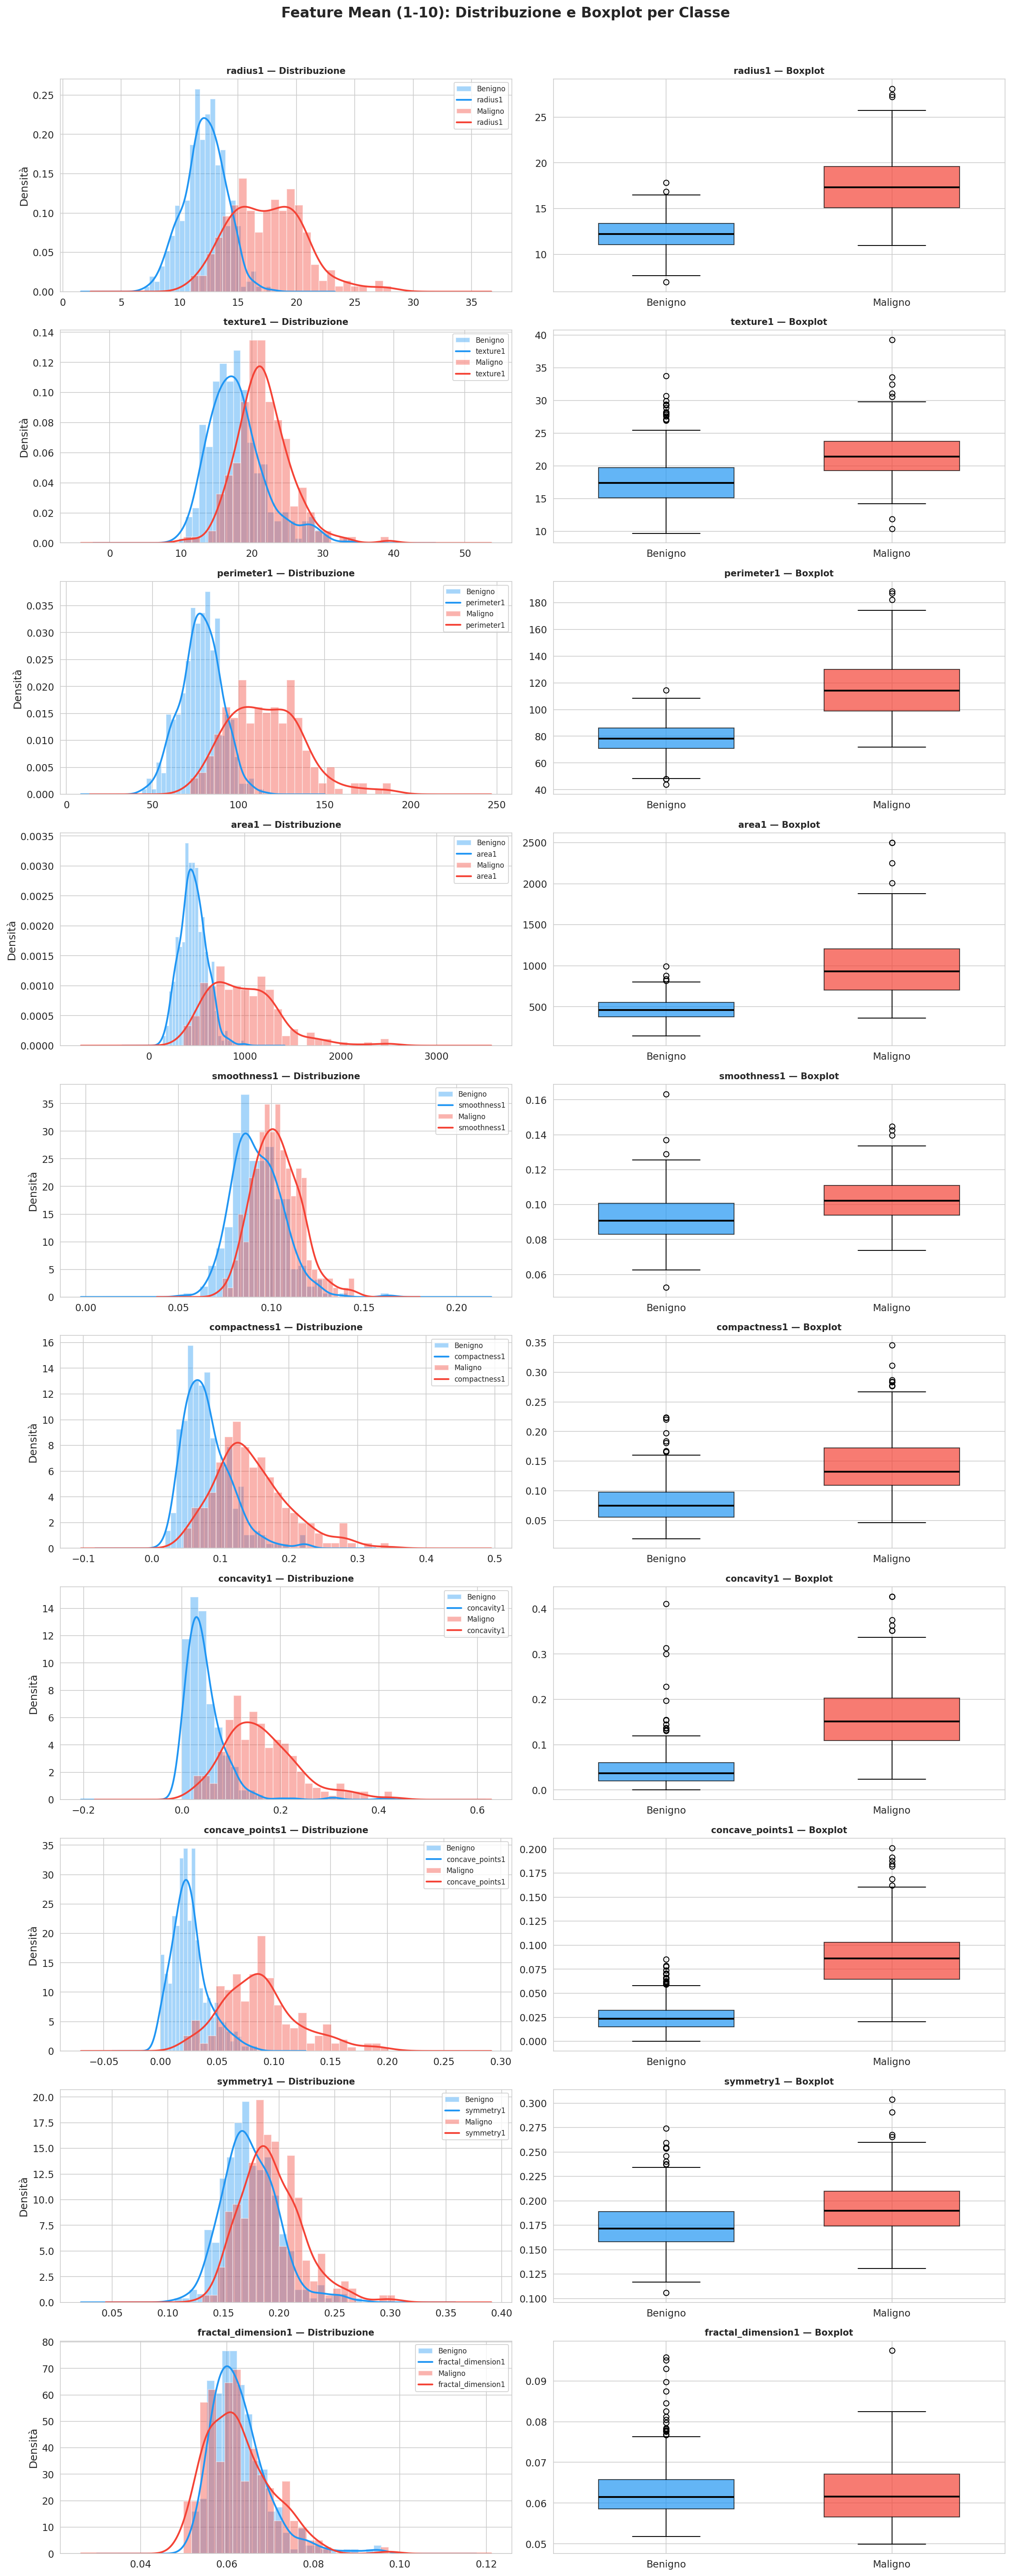

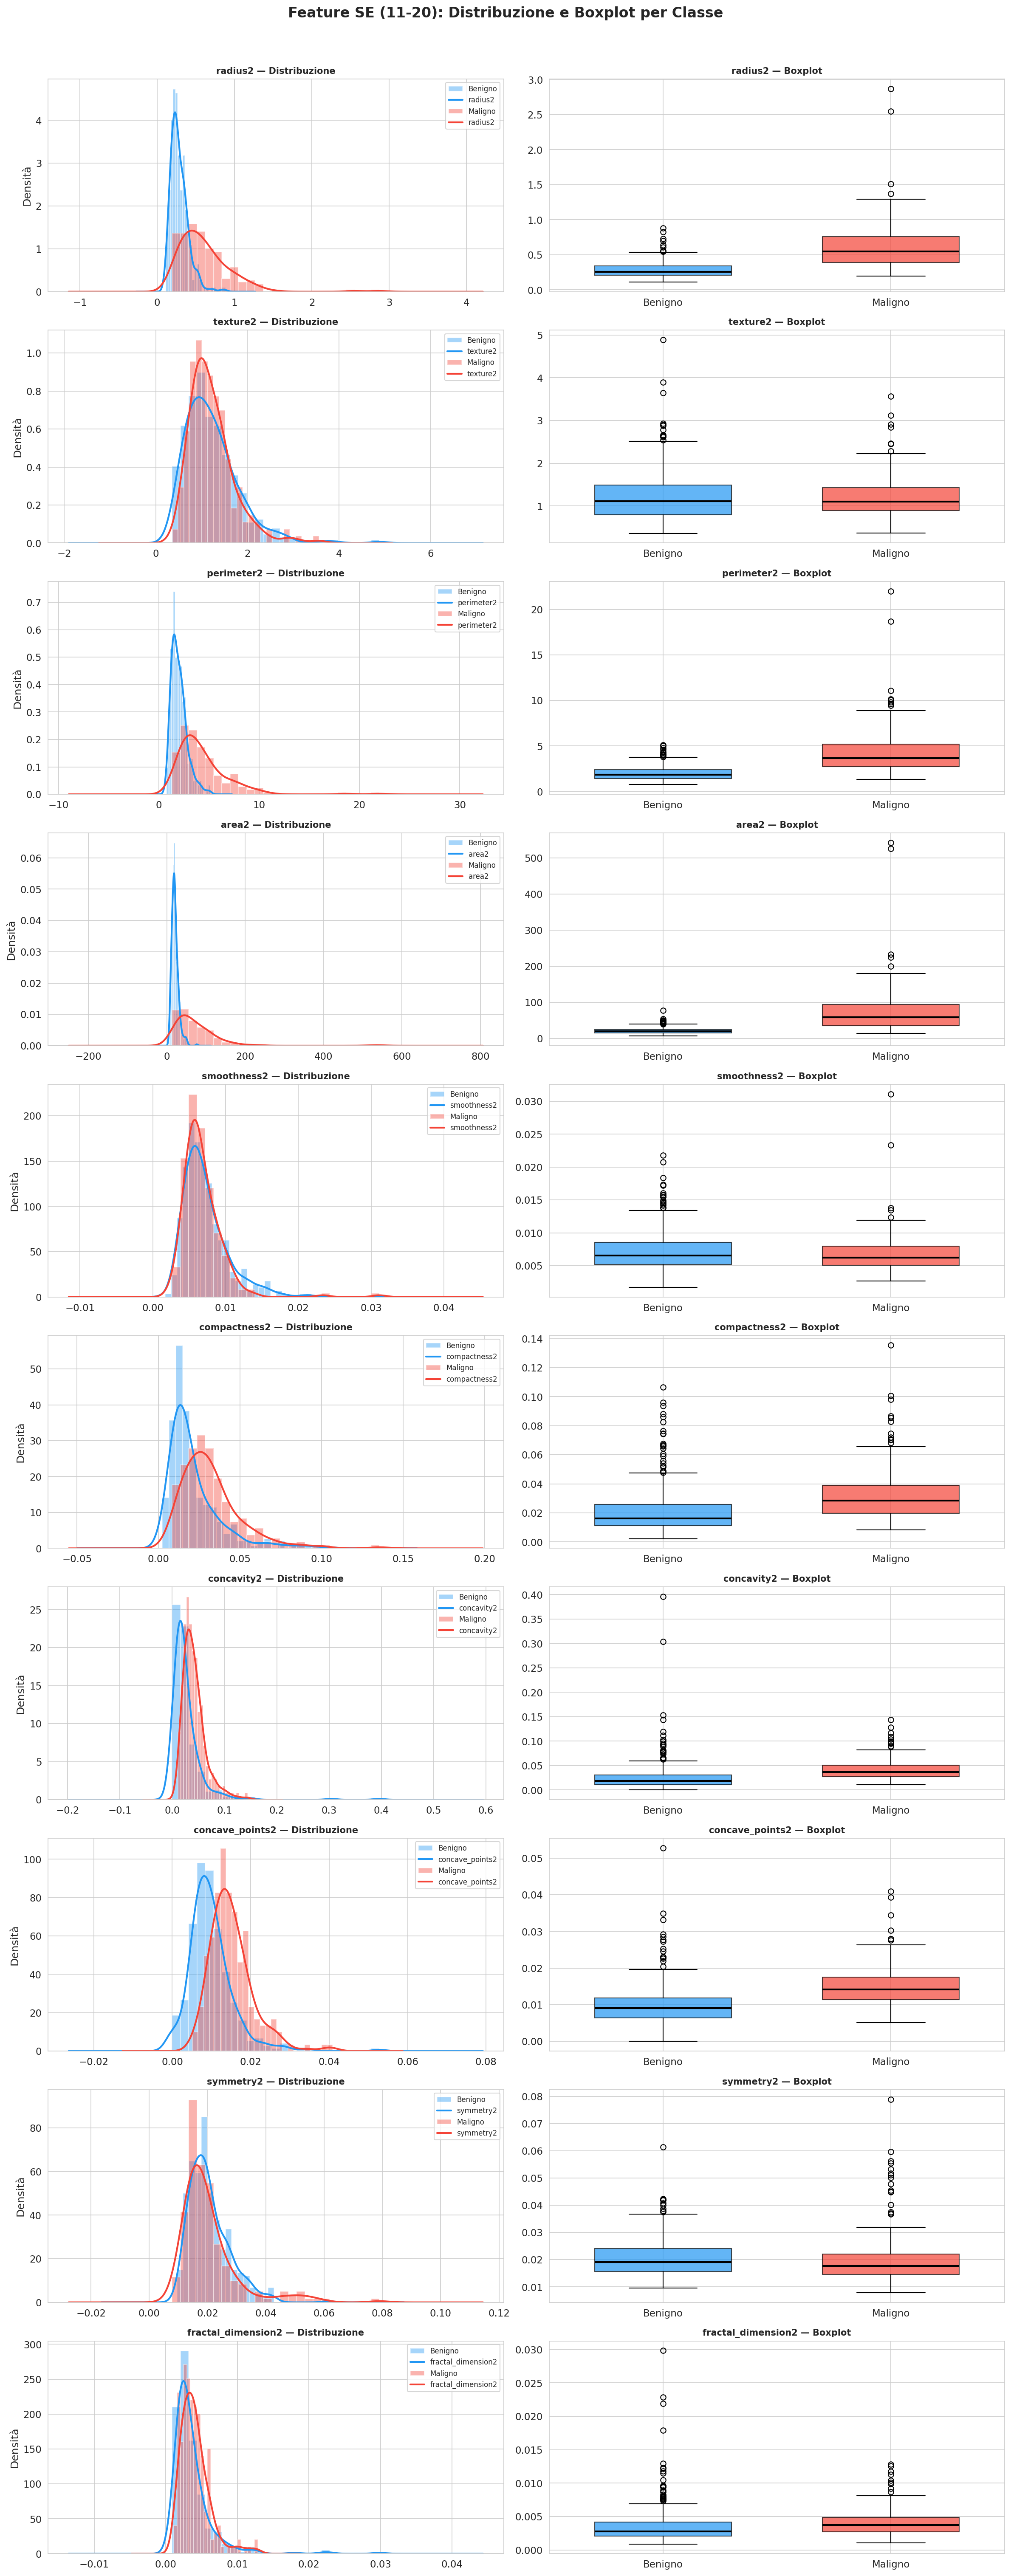

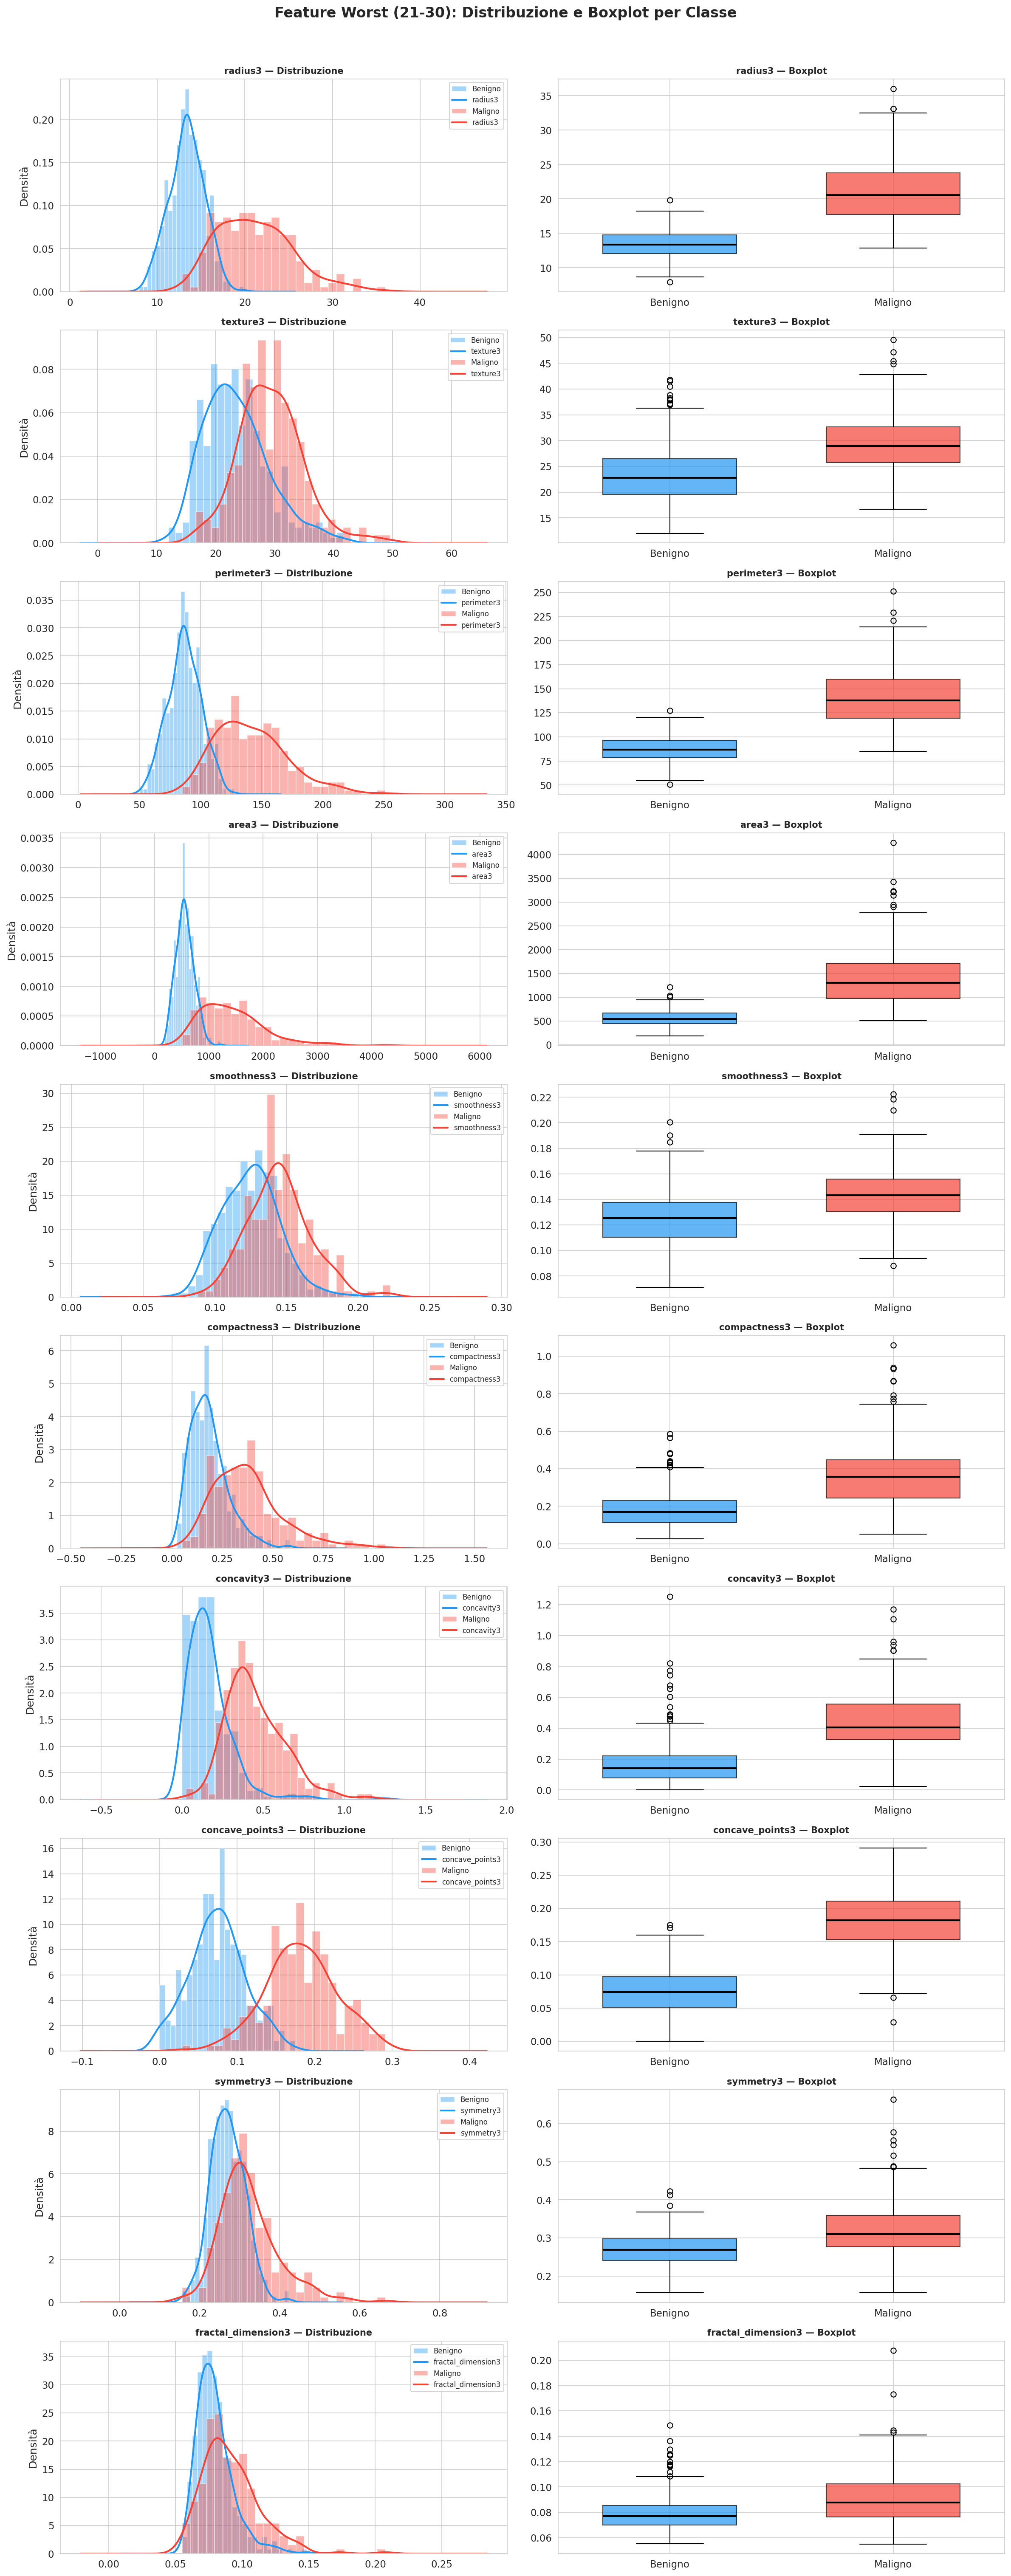

In [66]:
# Distribuzione + Boxplot per tutte le 30 feature, raggruppate per tipologia

feature_groups = {
    'Mean (1-10)': list(X.columns[:10]),
    'SE (11-20)': list(X.columns[10:20]),
    'Worst (21-30)': list(X.columns[20:30]),
}

for group_name, cols in feature_groups.items():
    fig, axes = plt.subplots(len(cols), 2, figsize=(16, 4 * len(cols)))

    for i, col in enumerate(cols):
        # --- Istogramma + KDE (sinistra) ---
        ax_hist = axes[i, 0]
        for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
            data = df[df['Diagnosis'] == cls][col]
            ax_hist.hist(data, bins=25, alpha=0.4, color=color, label=label, edgecolor='white', density=True)
            data.plot.kde(ax=ax_hist, color=color, linewidth=2)
        ax_hist.set_title(f'{col} — Distribuzione', fontweight='bold', fontsize=10)
        ax_hist.legend(fontsize=8)
        ax_hist.set_ylabel('Densità')

        # --- Boxplot (destra) ---
        ax_box = axes[i, 1]
        data_b = df[df['Diagnosis'] == 'B'][col]
        data_m = df[df['Diagnosis'] == 'M'][col]
        bp = ax_box.boxplot([data_b, data_m], tick_labels=['Benigno', 'Maligno'],
                            patch_artist=True, widths=0.6,
                            medianprops=dict(color='black', linewidth=2))
        bp['boxes'][0].set_facecolor('#2196F3')
        bp['boxes'][0].set_alpha(0.7)
        bp['boxes'][1].set_facecolor('#F44336')
        bp['boxes'][1].set_alpha(0.7)
        ax_box.set_title(f'{col} — Boxplot', fontweight='bold', fontsize=10)

    fig.suptitle(f'Feature {group_name}: Distribuzione e Boxplot per Classe',
                 fontweight='bold', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()


### 3.5 Identificazione Outlier

In [47]:
def count_outliers_iqr(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return ((series < Q1 - k * IQR) | (series > Q3 + k * IQR)).sum()

outlier_counts = X.apply(count_outliers_iqr)
outlier_pct = (outlier_counts / len(X) * 100).round(2)

outlier_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'N. Outlier': outlier_counts.values,
    '% Outlier': outlier_pct.values
}).sort_values('N. Outlier', ascending=False)

display(outlier_df.head(30).reset_index(drop=True))

Feature  N. Outlier  % Outlier
0                area2          65      11.42
1              radius2          38       6.68
2           perimeter2          38       6.68
3                area3          35       6.15
4          smoothness2          30       5.27
5   fractal_dimension2          28       4.92
6         compactness2          28       4.92
7            symmetry2          27       4.75
8                area1          25       4.39
9   fractal_dimension3          24       4.22
10           symmetry3          23       4.04
11          concavity2          22       3.87
12            texture2          20       3.51
13     concave_points2          19       3.34
14          concavity1          18       3.16
15             radius3          17       2.99
16        compactness3          16       2.81
17        compactness1          16       2.81
18           symmetry1          15       2.64
19  fractal_dimension1          15       2.64
20          perimeter3          15       2.64
21             radius1          14       2.46
22          perimeter1          13       2.28
23          concavity3          12       2.11
24     concave_points1          10       1.76
25            texture1           7       1.23
26         smoothness3           7       1.23
27         smoothness1           6       1.05
28            texture3           5       0.88
29     concave_points3           0       0.00

### 3.6 Analisi delle Correlazioni

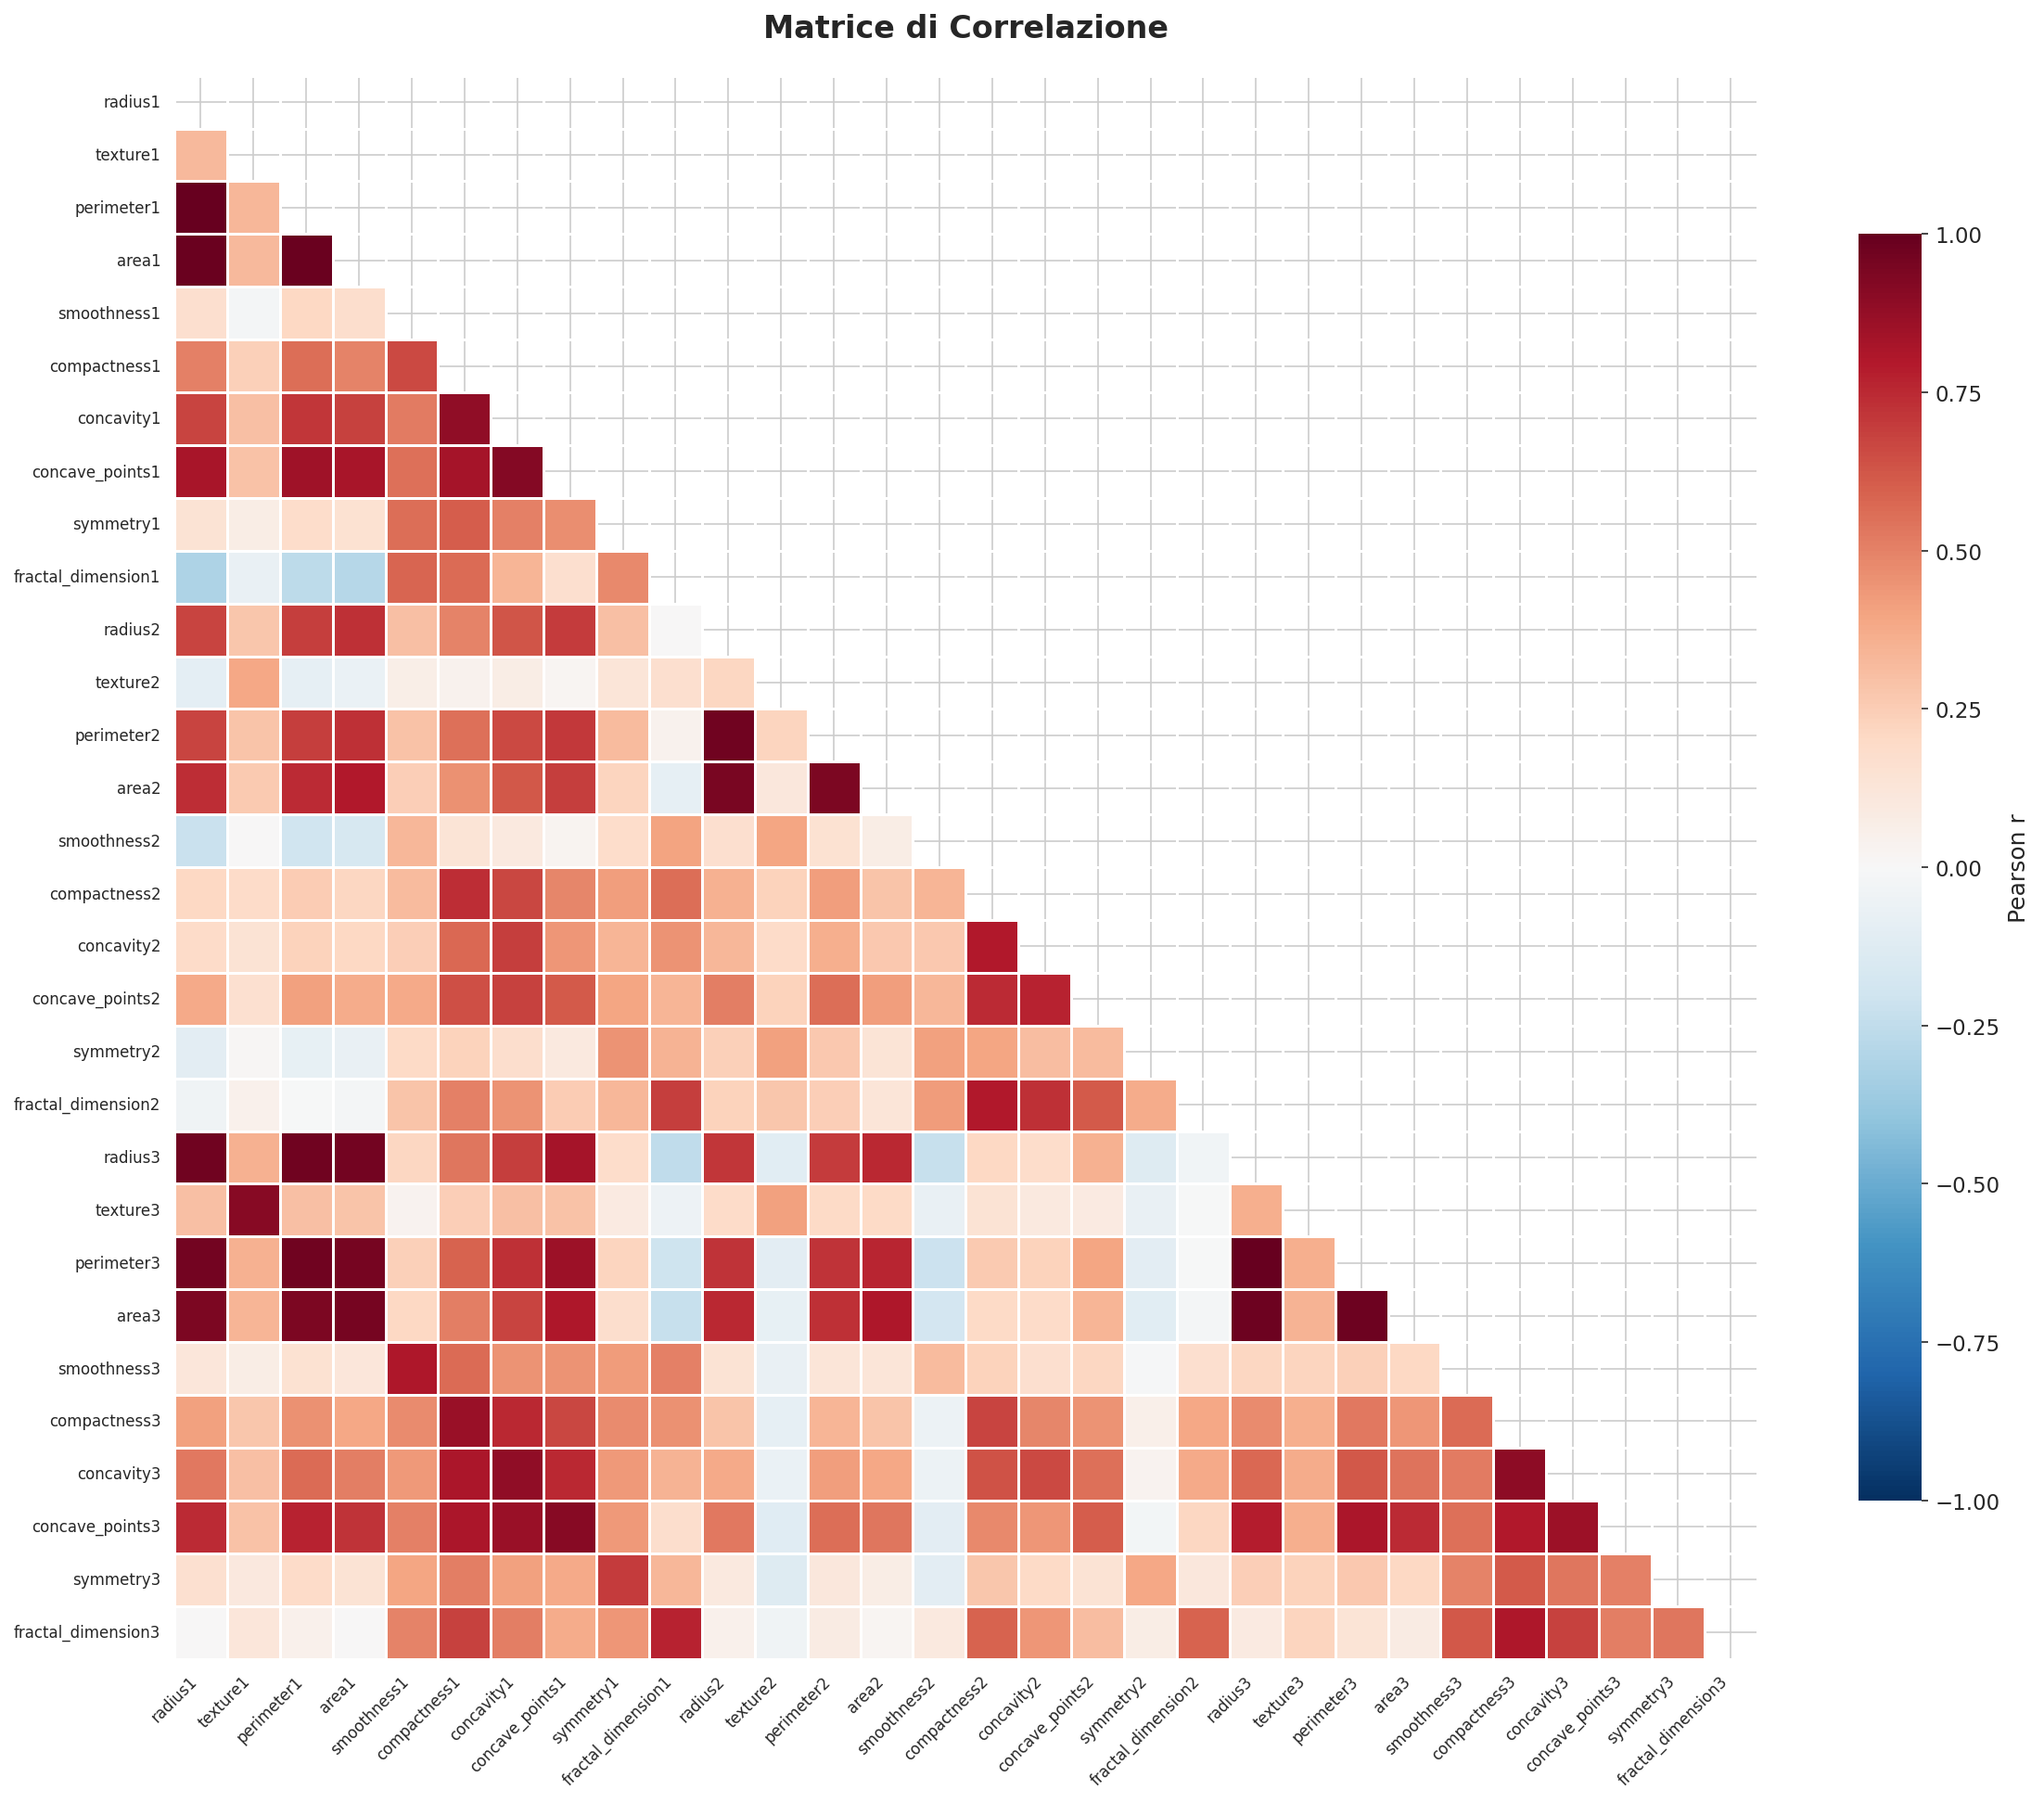

In [48]:
corr_matrix = X.corr()

fig, ax = plt.subplots(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson r'})
ax.set_title('Matrice di Correlazione', fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

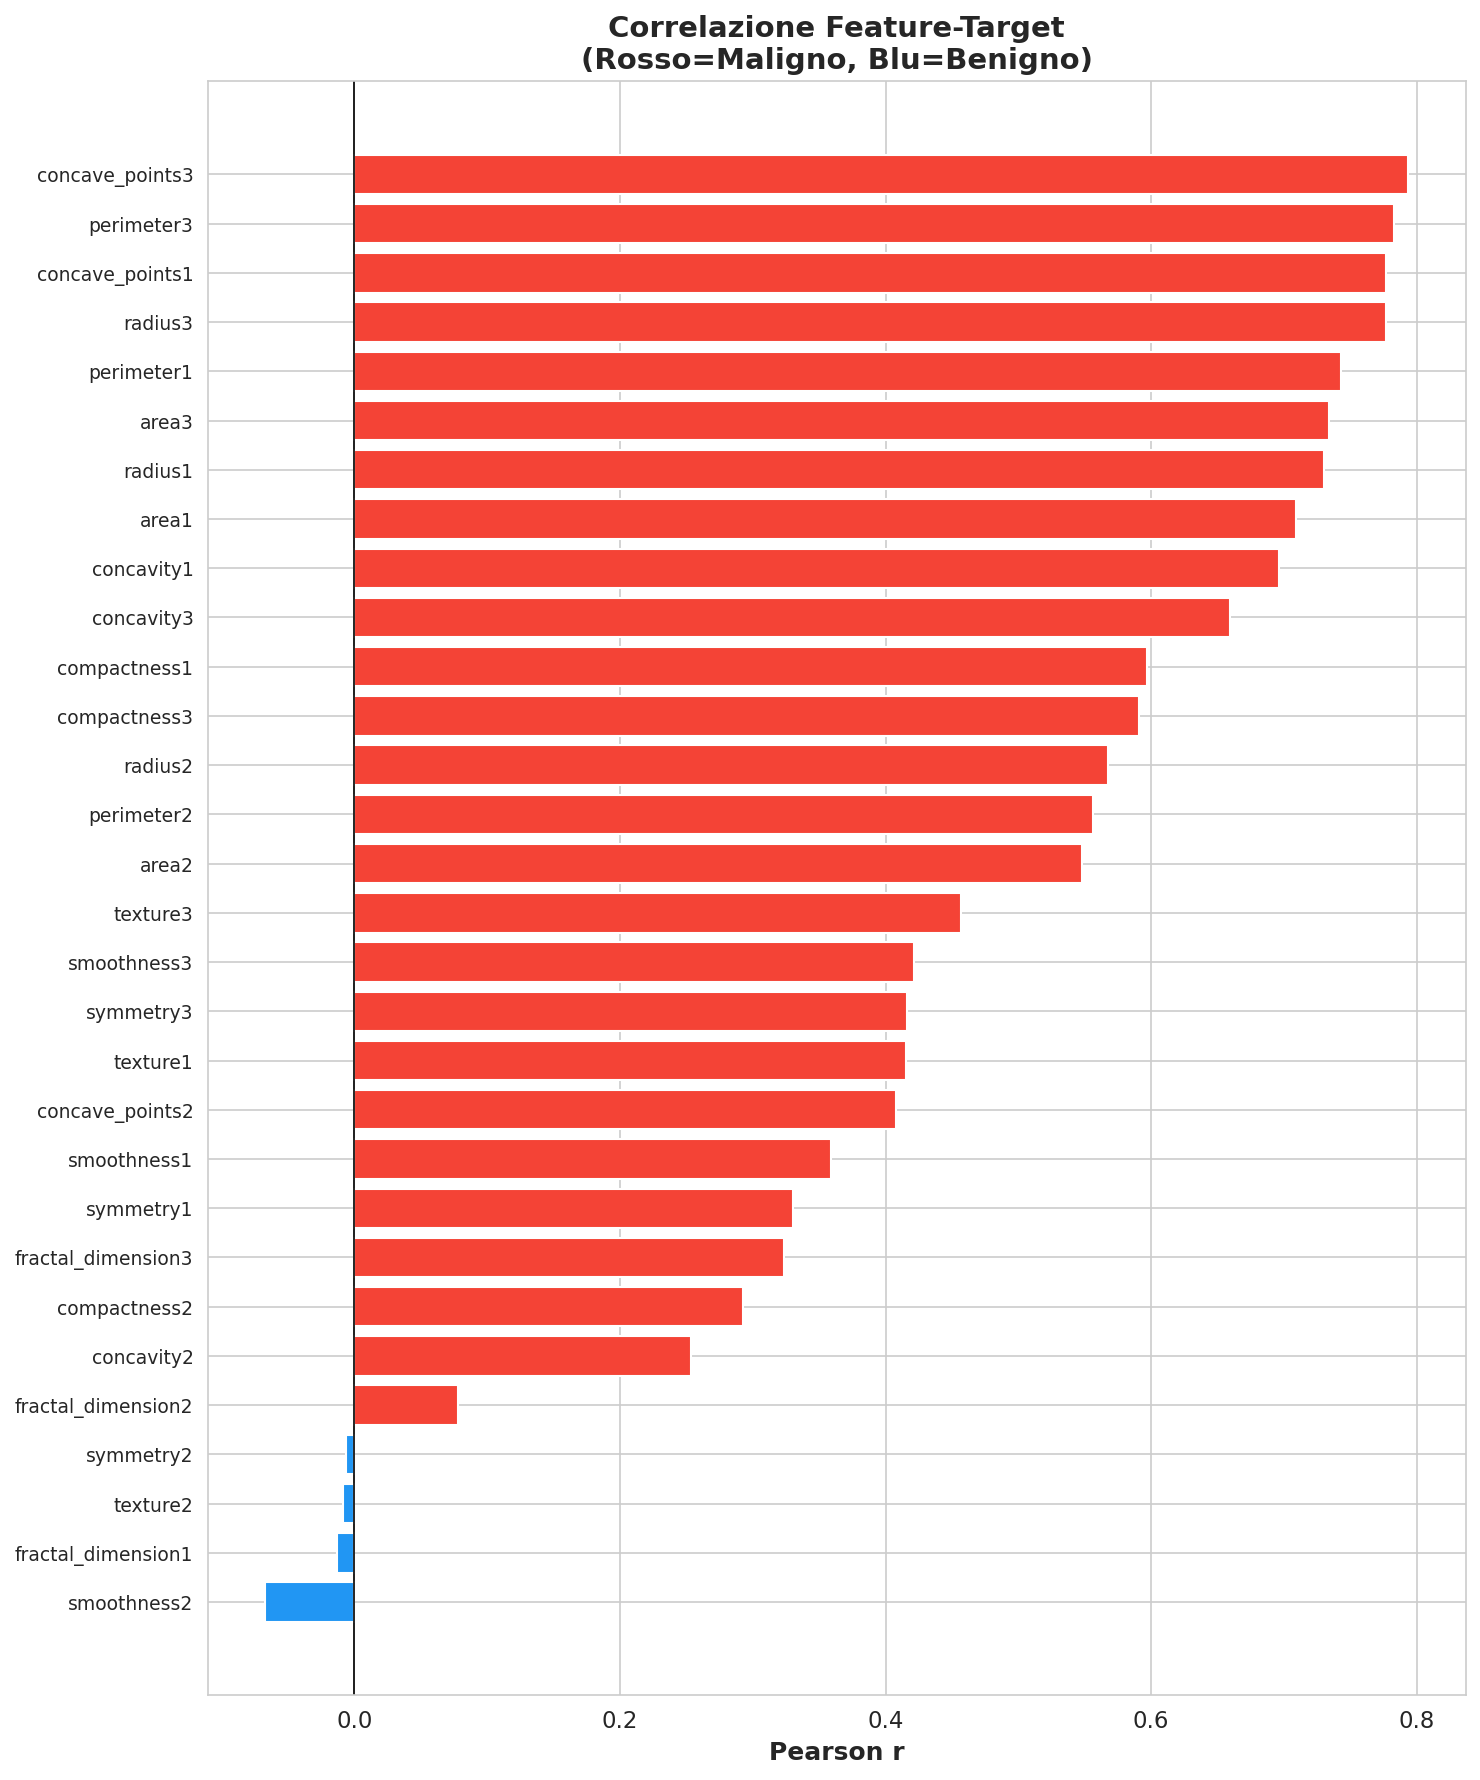

In [ ]:
corr_target = X.corrwith(pd.Series(y, index=X.index)).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
colors_bar = ['#F44336' if v > 0 else '#2196F3' for v in corr_target.values]
ax.barh(range(len(corr_target)), corr_target.values, color=colors_bar)
ax.set_yticks(range(len(corr_target)))
ax.set_yticklabels(corr_target.index, fontsize=9)
ax.set_xlabel('Pearson r', fontweight='bold')
ax.set_title('Correlazione Feature-Target\n(Rosso=Maligno, Blu=Benigno)', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 3.7 Pairplot Feature Principali

Top 5 feature per pairplot: ['concave_points3', 'perimeter3', 'concave_points1', 'radius3', 'perimeter1']


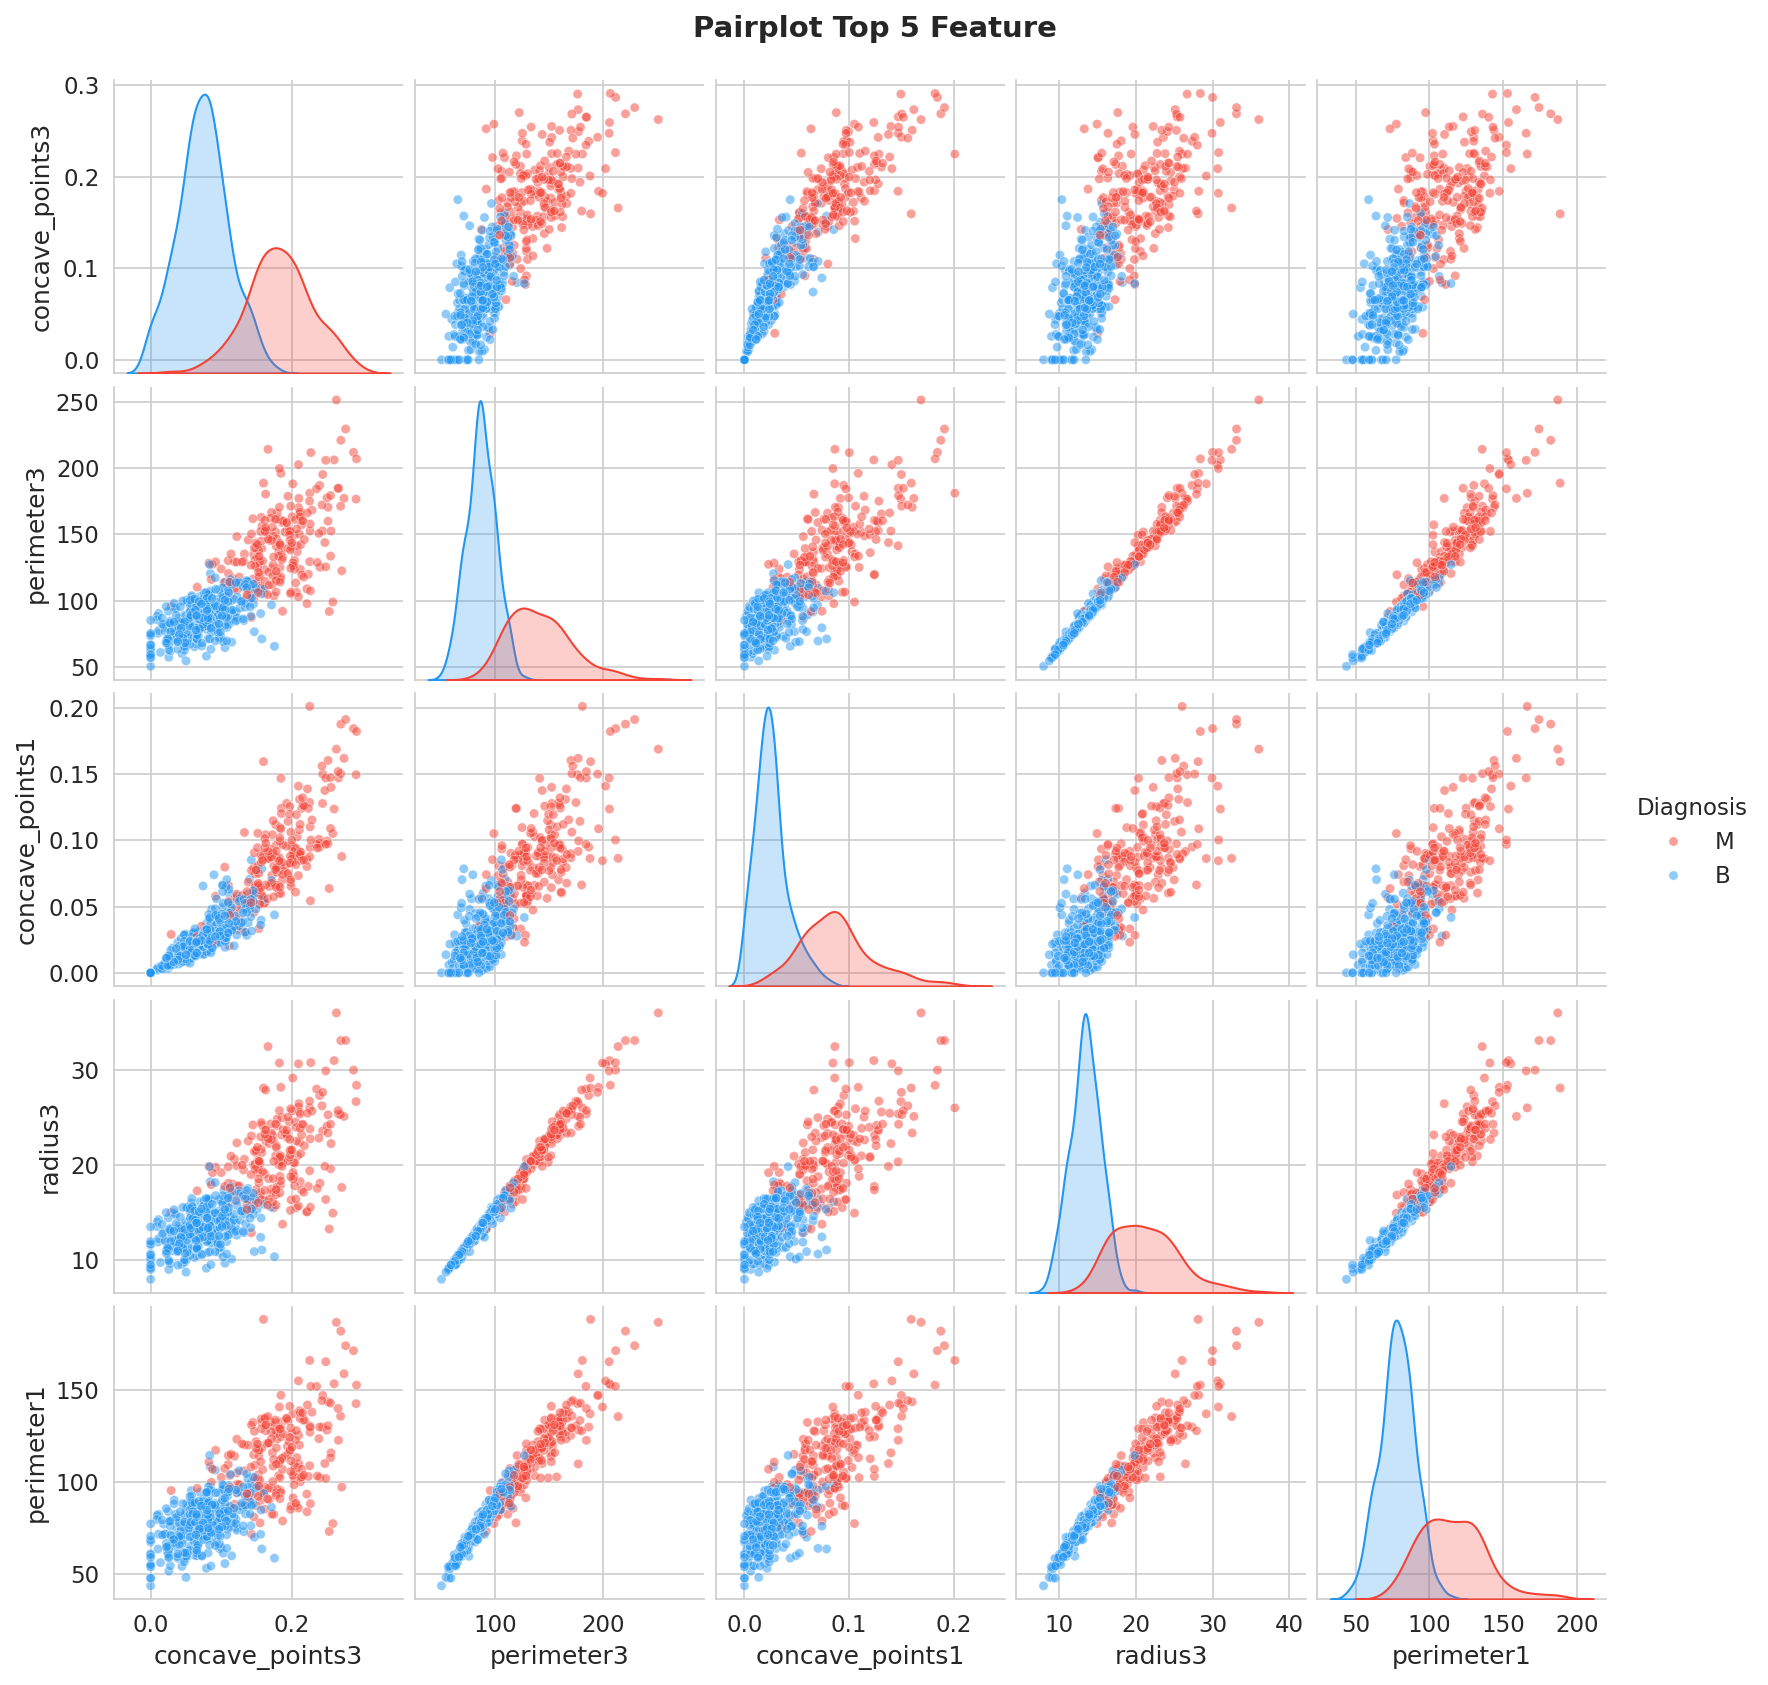

In [50]:
top5 = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()
print(f'Top 5 feature per pairplot: {top5}')

g = sns.pairplot(df[top5 + ['Diagnosis']], hue='Diagnosis',
                 palette={'B': '#2196F3', 'M': '#F44336'},
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20}, height=2.2)
g.figure.suptitle('Pairplot Top 5 Feature', fontweight='bold', fontsize=14, y=1.02)
plt.show()

---
## 4. Addestramento modelli

### 4.1 Test split stratificato

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'Training: {X_train.shape[0]} campioni ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test:     {X_test.shape[0]} campioni ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'\nDistribuzione classi:')
print(f'  Training - B: {(y_train==0).sum()}, M: {(y_train==1).sum()}')
print(f'  Test     - B: {(y_test==0).sum()}, M: {(y_test==1).sum()}')

Training: 455 campioni (80%)
Test:     114 campioni (20%)

Distribuzione classi:
  Training - B: 285, M: 170
  Test     - B: 72, M: 42


### 4.2 Analisi PCA — Varianza Spiegata e Scelta delle Componenti

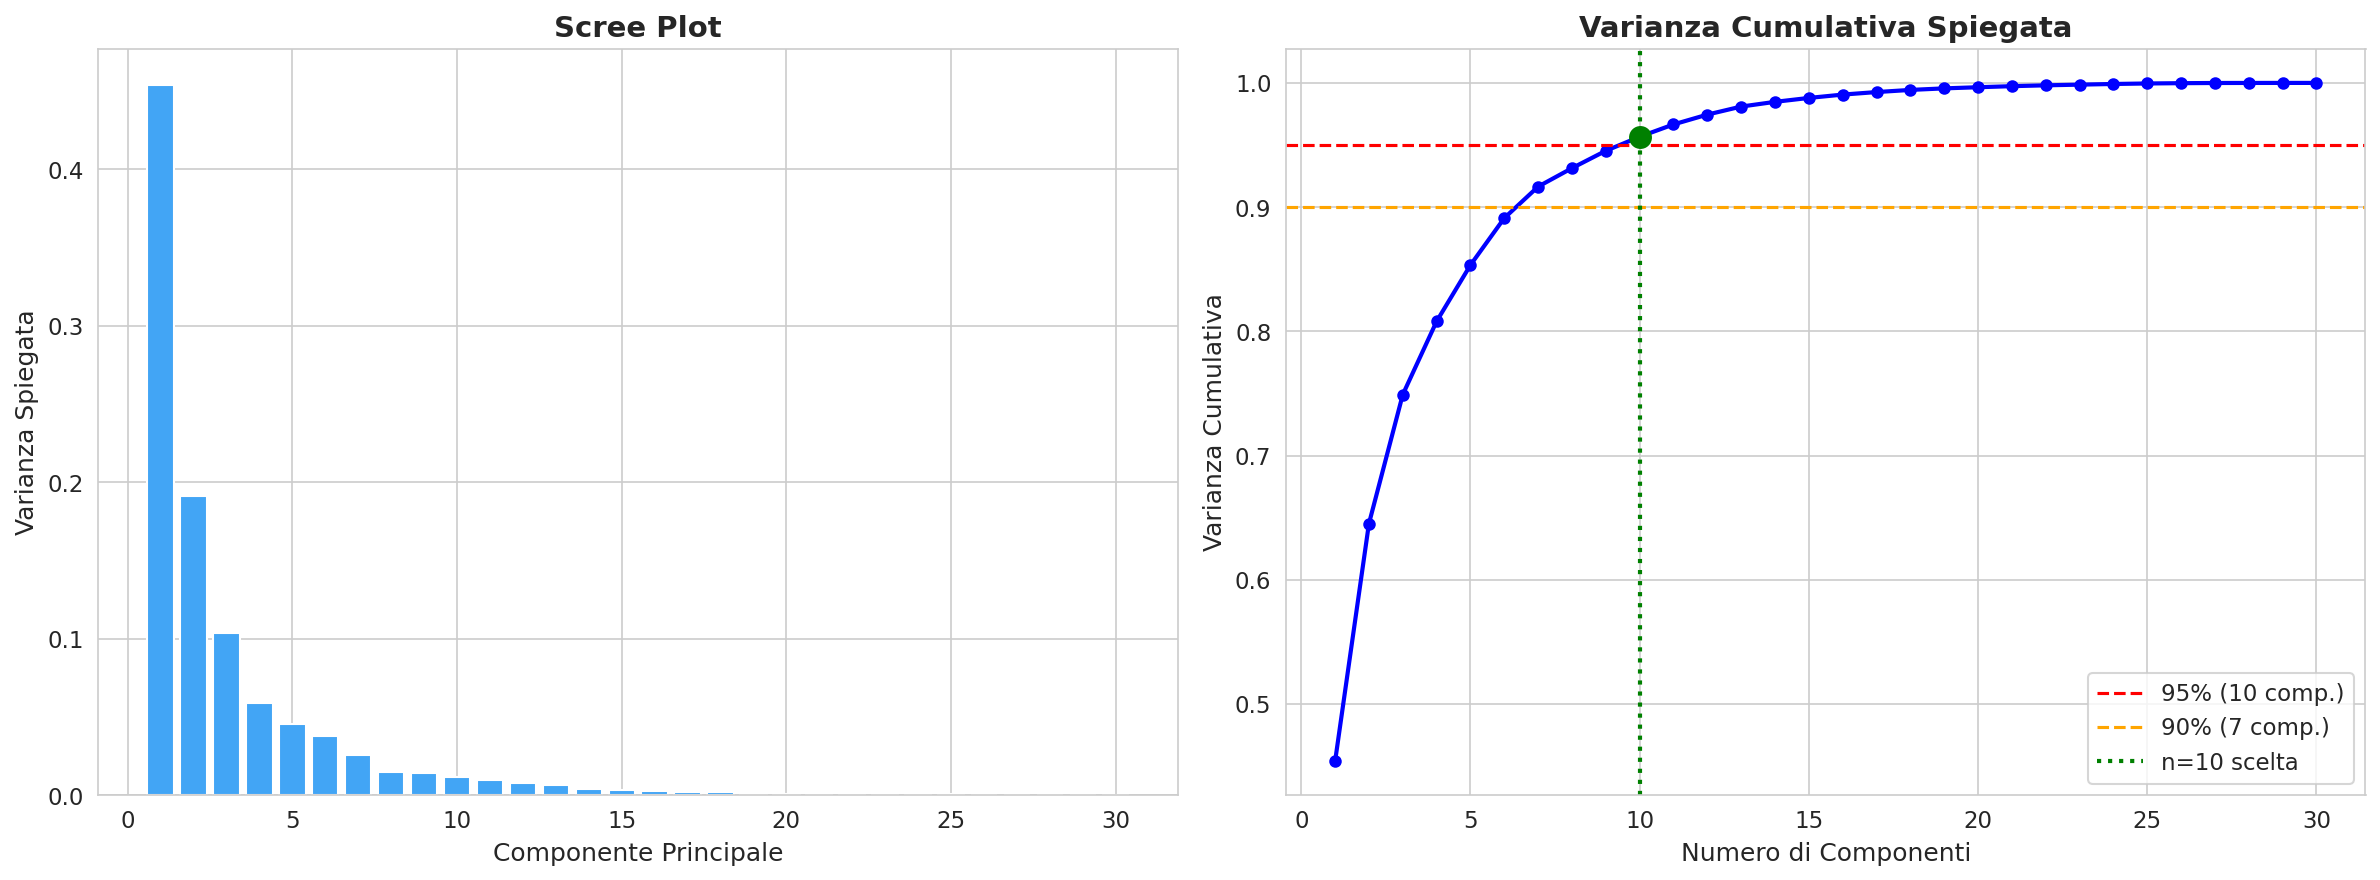

Componenti per 90% varianza: 7
Componenti per 95% varianza: 10
Varianza con 10 componenti:  95.66%
Varianza con 2 componenti:   64.52%


In [69]:
scaler_eda = RobustScaler()
X_train_scaled_eda = scaler_eda.fit_transform(X_train)

pca_eda = PCA()
pca_eda.fit(X_train_scaled_eda)
cumvar_eda = np.cumsum(pca_eda.explained_variance_ratio_)

n_95_eda = np.argmax(cumvar_eda >= 0.95) + 1
n_90_eda = np.argmax(cumvar_eda >= 0.90) + 1

# Grafico: Scree Plot + Varianza Cumulativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, 31), pca_eda.explained_variance_ratio_,
            color='#42A5F5', edgecolor='white')
axes[0].set_xlabel('Componente Principale')
axes[0].set_ylabel('Varianza Spiegata')
axes[0].set_title('Scree Plot', fontweight='bold')

axes[1].plot(range(1, 31), cumvar_eda, 'bo-', linewidth=2, markersize=5)
axes[1].axhline(y=0.95, color='r', linestyle='--', label=f'95% ({n_95_eda} comp.)')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label=f'90% ({n_90_eda} comp.)')
axes[1].axvline(x=10, color='green', linestyle=':', linewidth=2, label=f'n=10 scelta')
axes[1].scatter([10], [cumvar_eda[9]], color='green', s=100, zorder=5)
axes[1].set_xlabel('Numero di Componenti')
axes[1].set_ylabel('Varianza Cumulativa')
axes[1].set_title('Varianza Cumulativa Spiegata', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Componenti per 90% varianza: {n_90_eda}')
print(f'Componenti per 95% varianza: {n_95_eda}')
print(f'Varianza con 10 componenti:  {cumvar_eda[9]*100:.2f}%')
print(f'Varianza con 2 componenti:   {cumvar_eda[1]*100:.2f}%')

### 4.3 Heatmap dei loadings PCA — contributo di ogni feature originale alle prime componenti

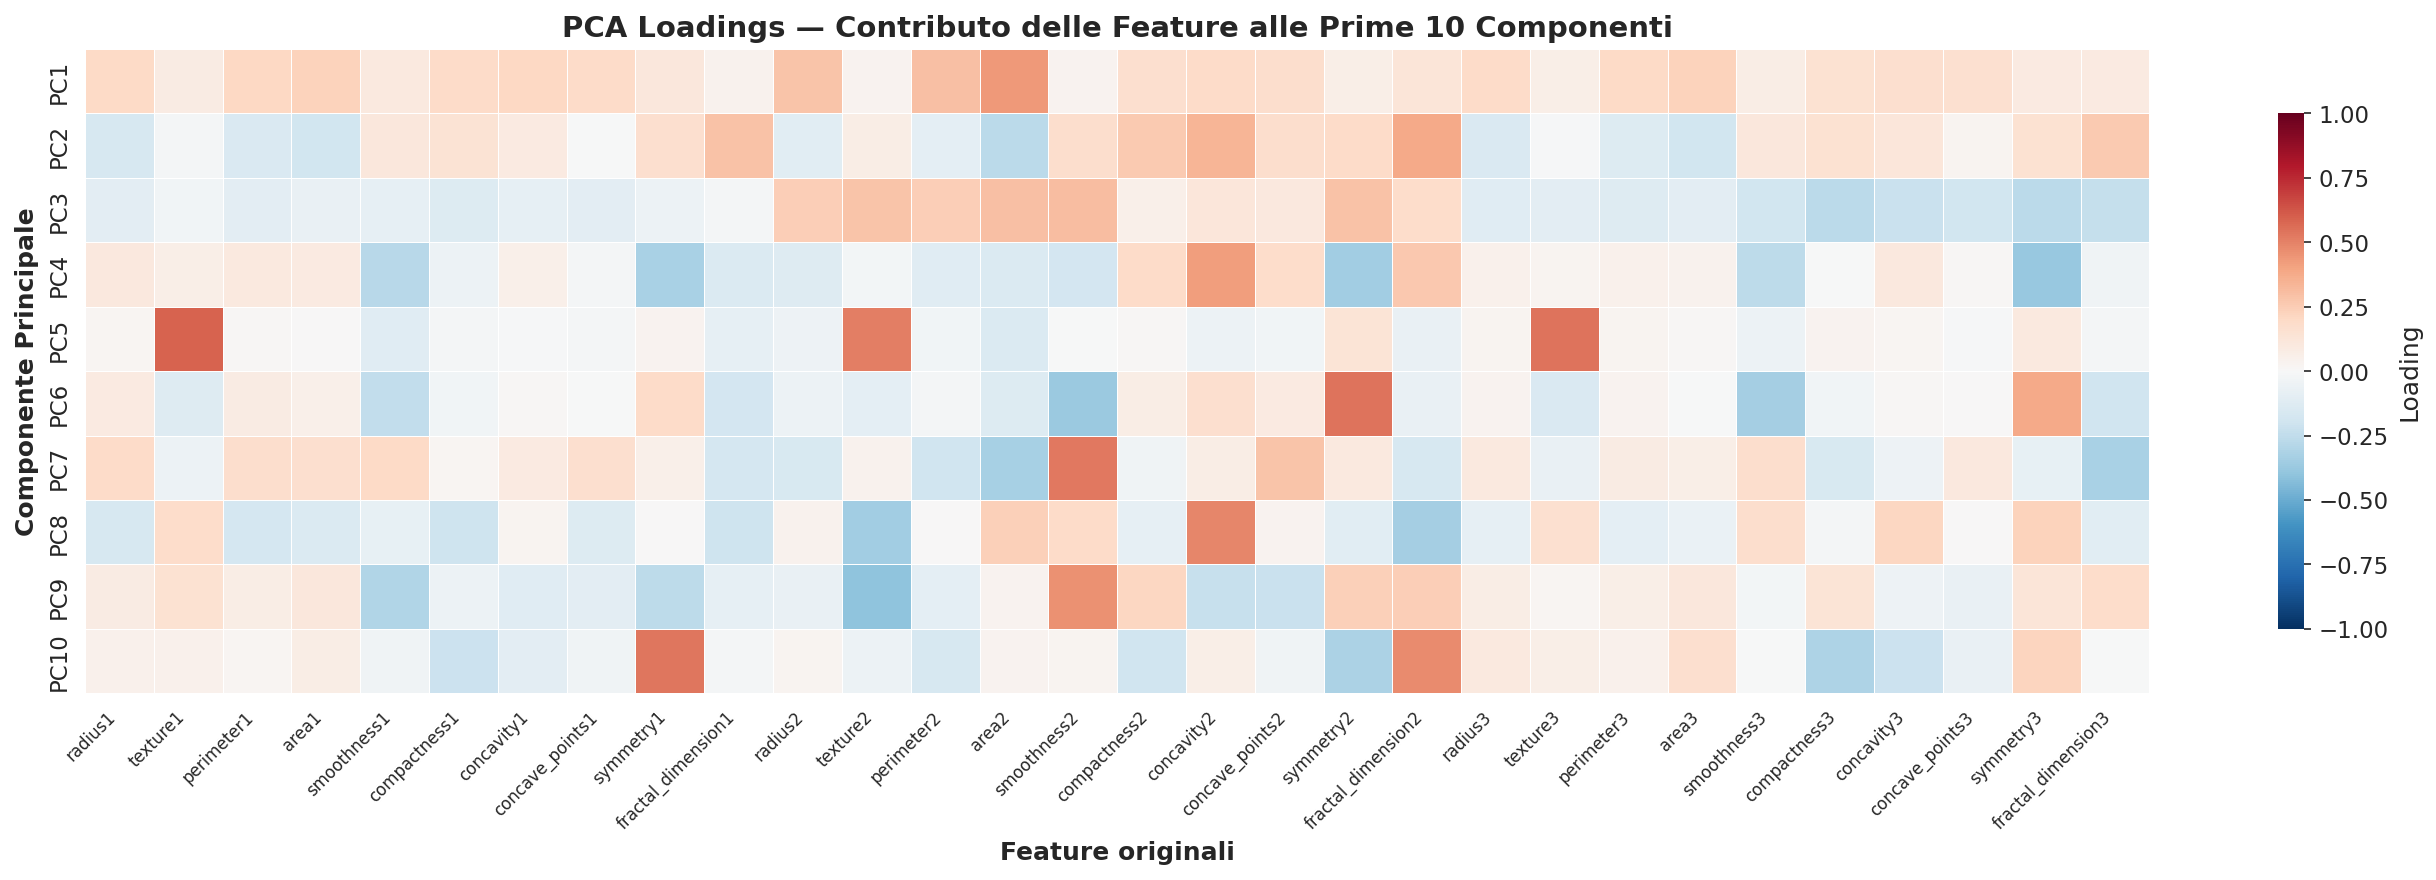

Top 5 feature per PC1:
area2         0.433507
perimeter2    0.304627
radius2       0.288988
area3         0.233713
area1         0.231795


In [70]:

n_show = 10
feature_names = list(X.columns)

loadings_df = pd.DataFrame(
    pca_eda.components_[:n_show],
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(n_show)]
)

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(
    loadings_df,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.3,
    annot=False,
    ax=ax,
    cbar_kws={'label': 'Loading', 'shrink': 0.8}
)
ax.set_title('PCA Loadings — Contributo delle Feature alle Prime 10 Componenti', fontweight='bold', fontsize=14)
ax.set_xlabel('Feature originali', fontweight='bold')
ax.set_ylabel('Componente Principale', fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

print('Top 5 feature per PC1:')
print(loadings_df.loc['PC1'].abs().sort_values(ascending=False).head(5).to_string())

### 4.3 Definizione pipeline

In [54]:
svm_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=RANDOM_STATE
    ))
])

dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

pipelines = {
    'SVM (RBF)': svm_pipeline,
    'Decision Tree (CART)': dt_pipeline,
}

### 4.4 Cross-Validation (10-Fold Stratificata)

In [55]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

for name, pipe in pipelines.items():
    cv_res = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring=scoring_metrics,
        n_jobs=-1
    )
    cv_results[name] = cv_res

cv_summary = []
for name in pipelines:
    row = {'Modello': name}
    for metric in scoring_metrics:
        key = f'test_{metric}'
        m = cv_results[name][key].mean()
        s = cv_results[name][key].std()
        row[metric.upper()] = f'{m:.4f} +/- {s:.4f}'
    cv_summary.append(row)

display(pd.DataFrame(cv_summary))

Modello           ACCURACY          PRECISION  \
0             SVM (RBF)  0.9647 +/- 0.0283  0.9599 +/- 0.0355   
1  Decision Tree (CART)  0.9362 +/- 0.0422  0.9079 +/- 0.0518   

              RECALL                 F1            ROC_AUC  
0  0.9471 +/- 0.0718  0.9516 +/- 0.0403  0.9933 +/- 0.0097  
1  0.9235 +/- 0.0791  0.9145 +/- 0.0588  0.9337 +/- 0.0487

### 4.5 Hyperparameter Tuning (GridSearchCV)

In [56]:

svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.001],
}

dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy'],
}

param_grids = {
    'SVM (RBF)': svm_param_grid,
    'Decision Tree (CART)': dt_param_grid,
}

best_models = {}

for name, pipe in pipelines.items():
    n_comb = 1
    for vals in param_grids[name].values():
        n_comb *= len(vals)
    print(f'{name}: {n_comb} combinazioni x 10 fold')

    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        refit=True
    )
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print(f'  Migliori parametri: {grid.best_params_}')
    print(f'  Miglior F1 (CV):    {grid.best_score_:.4f}')

SVM (RBF): 16 combinazioni x 10 fold
  Migliori parametri: {'classifier__C': 100, 'classifier__gamma': 0.001}
  Miglior F1 (CV):    0.9674
Decision Tree (CART): 120 combinazioni x 10 fold
  Migliori parametri: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
  Miglior F1 (CV):    0.9268


### 4.6 Cost-Complexity Pruning — Decision Tree

Pruning path: 14 valori di alpha
  Range: [0.000000, 0.352164]

  Alpha ottimale:     0.000000
  F1 (CV):            0.9268 ± 0.0445
  Recall (CV):        0.9353
  Delta F1 vs no-pruning: +0.0000


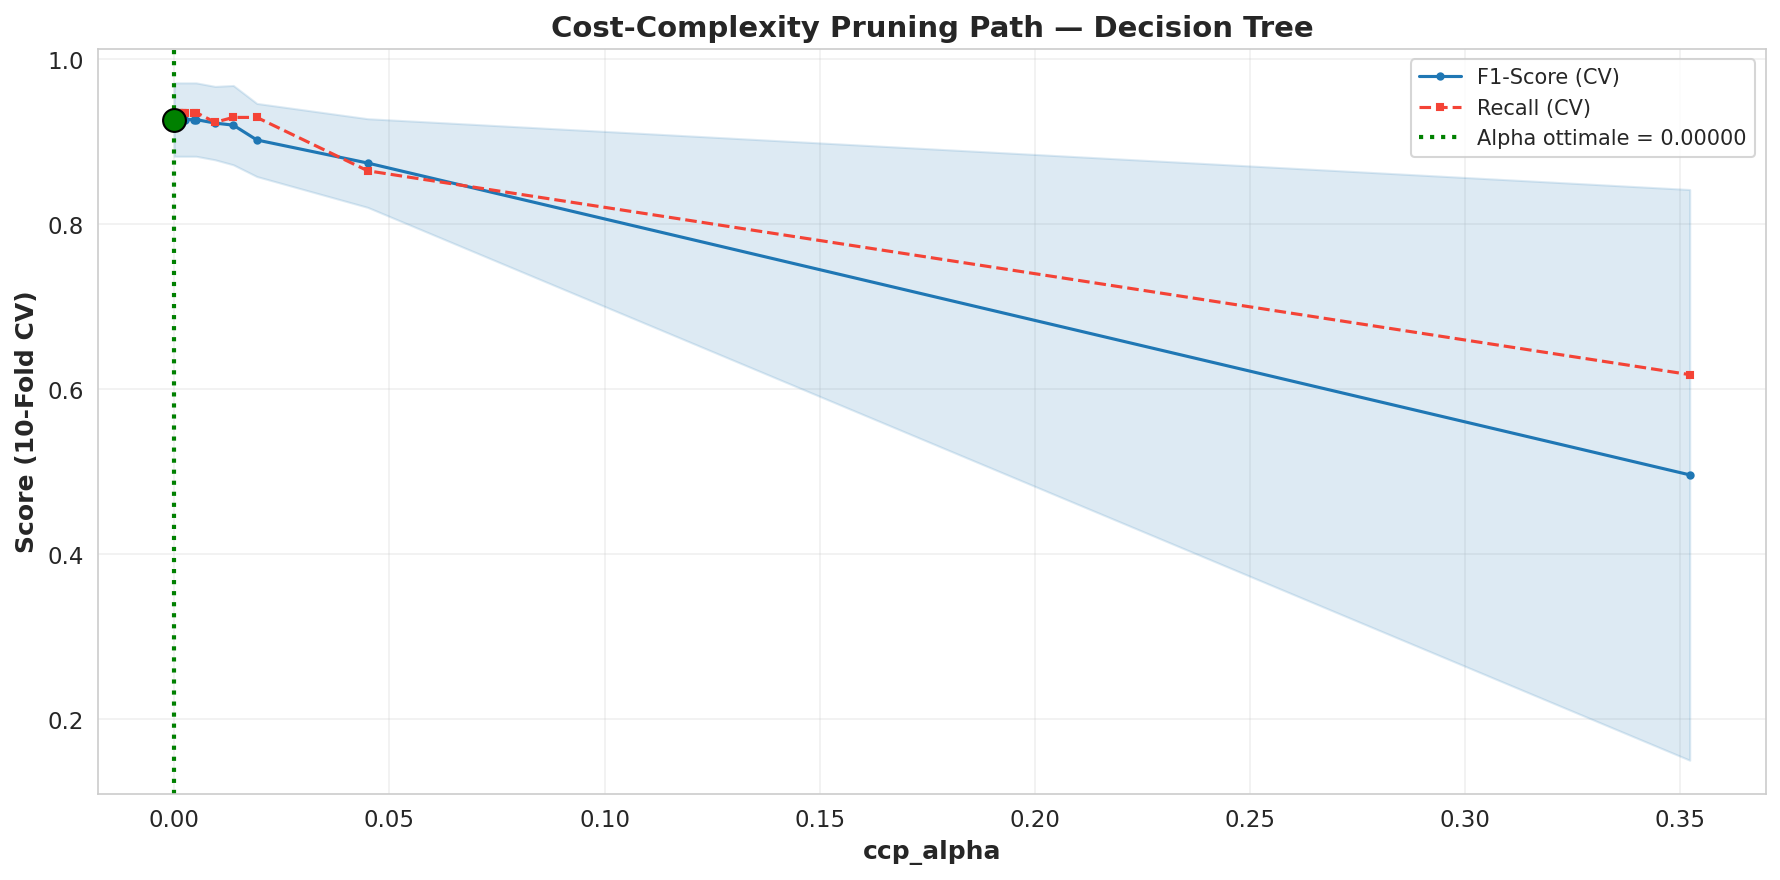


Confronto albero:
  Pre-pruning:  29 nodi, profondità 7
  Post-pruning: 29 nodi, profondità 7


In [ ]:
dt_best = best_models['Decision Tree (CART)'].named_steps['classifier']

dt_params = dict(
    criterion=dt_best.criterion,
    max_depth=dt_best.max_depth,
    min_samples_split=dt_best.min_samples_split,
    min_samples_leaf=dt_best.min_samples_leaf,
    max_features=dt_best.max_features,
    class_weight='balanced',
    random_state=RANDOM_STATE,
)

dt_full = DecisionTreeClassifier(**dt_params)
dt_full.fit(X_train, y_train)

path = dt_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
print(f'Pruning path: {len(ccp_alphas)} valori di alpha')
print(f'  Range: [{ccp_alphas.min():.6f}, {ccp_alphas.max():.6f}]')

f1_means, f1_stds, recall_means = [], [], []

for alpha in ccp_alphas:
    dt_temp = DecisionTreeClassifier(**dt_params, ccp_alpha=alpha)
    scores_f1 = cross_val_score(dt_temp, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    scores_recall = cross_val_score(dt_temp, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
    f1_means.append(scores_f1.mean())
    f1_stds.append(scores_f1.std())
    recall_means.append(scores_recall.mean())

f1_means = np.array(f1_means)
f1_stds = np.array(f1_stds)
recall_means = np.array(recall_means)

best_idx = np.argmax(f1_means)
best_alpha = ccp_alphas[best_idx]

print(f'\n  Alpha ottimale:     {best_alpha:.6f}')
print(f'  F1 (CV):            {f1_means[best_idx]:.4f} ± {f1_stds[best_idx]:.4f}')
print(f'  Recall (CV):        {recall_means[best_idx]:.4f}')
print(f'  Delta F1 vs no-pruning: {f1_means[best_idx] - f1_means[0]:+.4f}')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ccp_alphas, f1_means, 'o-', color='#1f77b4', markersize=3, linewidth=1.5, label='F1-Score (CV)')
ax.fill_between(ccp_alphas, f1_means - f1_stds, f1_means + f1_stds, alpha=0.15, color='#1f77b4')
ax.plot(ccp_alphas, recall_means, 's--', color='#F44336', markersize=3, linewidth=1.5, label='Recall (CV)')
ax.axvline(x=best_alpha, color='green', linestyle=':', linewidth=2, label=f'Alpha ottimale = {best_alpha:.5f}')
ax.scatter([best_alpha], [f1_means[best_idx]], color='green', s=120, zorder=5, edgecolors='black')
ax.set_xlabel('ccp_alpha', fontweight='bold')
ax.set_ylabel('Score (10-Fold CV)', fontweight='bold')
ax.set_title('Cost-Complexity Pruning Path — Decision Tree', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

dt_pruned = DecisionTreeClassifier(**dt_params, ccp_alpha=best_alpha)
dt_pruned.fit(X_train, y_train)

best_models['Decision Tree (CART)'] = Pipeline([('classifier', dt_pruned)])

print(f'\nConfronto albero:')
print(f'  Pre-pruning:  {dt_full.tree_.node_count} nodi, profondità {dt_full.get_depth()}')
print(f'  Post-pruning: {dt_pruned.tree_.node_count} nodi, profondità {dt_pruned.get_depth()}')

---
## 5. Analisi dei risultati

### 5.1 Valutazione sul Test Set

In [58]:
predictions = {}
test_results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}

    metrics = {
        'Modello': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    }
    test_results.append(metrics)

results_df = pd.DataFrame(test_results)
display(results_df.round(4))

print("Risultati dettagliati:")
for name, preds in predictions.items():
    report = classification_report(
        y_test, preds['y_pred'],
        target_names=[f'{c} ({i})' for i, c in enumerate(le.classes_)],
        output_dict=True
    )
    report_df = pd.DataFrame(report).T.drop(columns='support').round(4).astype(object)
    report_df.loc['accuracy', ['precision', 'recall']] = ''
    print(name)
    display(report_df)
    print()

Modello  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0             SVM (RBF)    0.9912     1.0000  0.9762     0.988   0.9974
1  Decision Tree (CART)    0.9123     0.9211  0.8333     0.875   0.9261

Risultati dettagliati:
SVM (RBF)


precision  recall f1-score
B (0)           0.9863     1.0   0.9931
M (1)              1.0  0.9762    0.988
accuracy                         0.9912
macro avg       0.9932  0.9881   0.9905
weighted avg    0.9913  0.9912   0.9912


Decision Tree (CART)


precision  recall f1-score
B (0)           0.9079  0.9583   0.9324
M (1)           0.9211  0.8333    0.875
accuracy                         0.9123
macro avg       0.9145  0.8958   0.9037
weighted avg    0.9127  0.9123   0.9113

### 5.2 Matrici di confusione

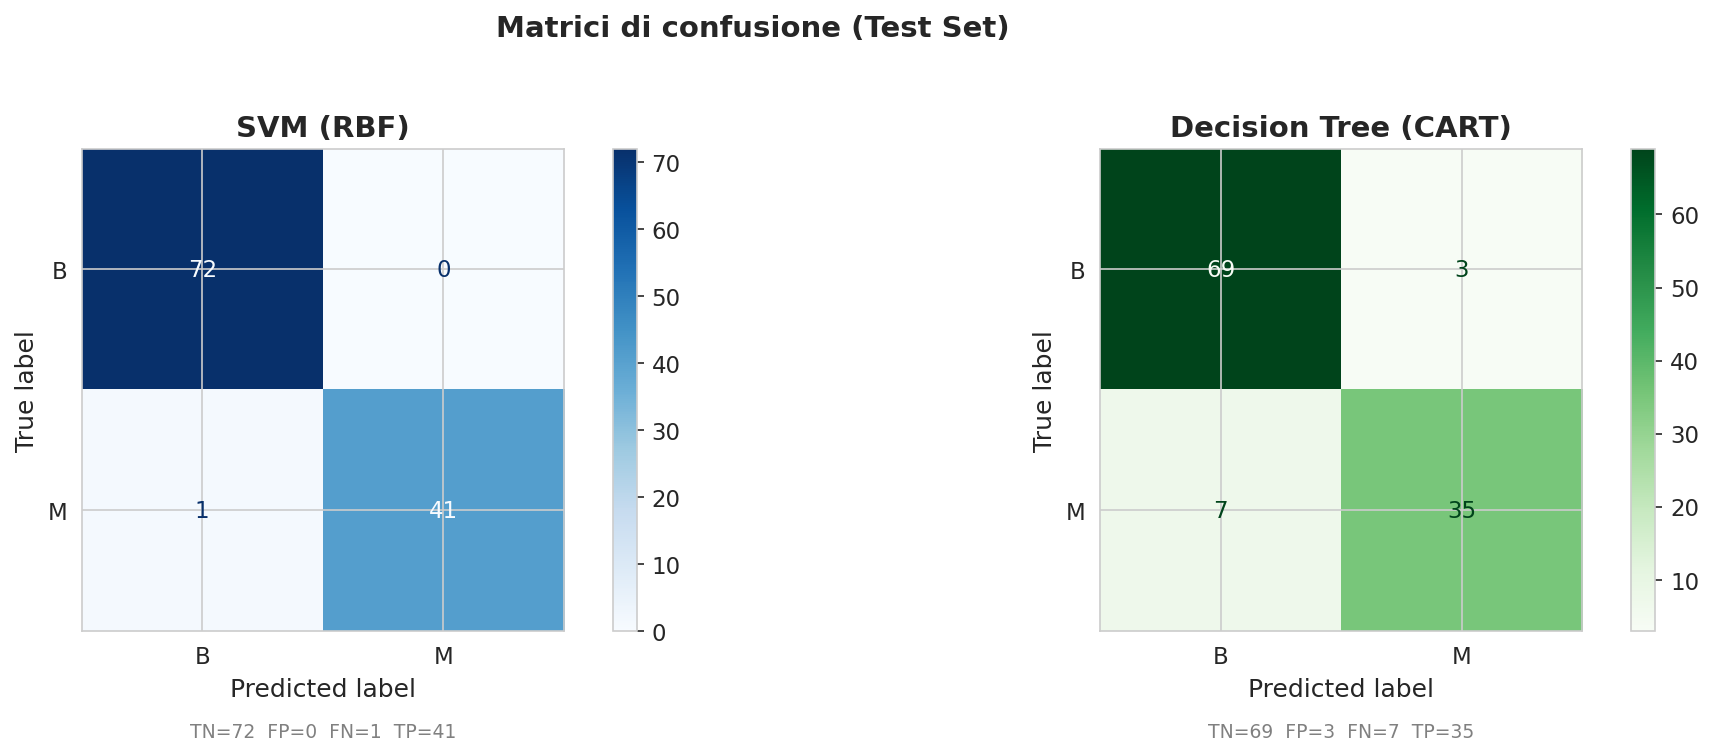

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cmaps = ['Blues', 'Greens']

for i, (name, preds) in enumerate(predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_test, preds['y_pred'],
        display_labels=le.classes_,
        cmap=cmaps[i],
        ax=axes[i]
    )
    axes[i].set_title(f'{name}', fontweight='bold')

    cm = confusion_matrix(y_test, preds['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    axes[i].text(0.5, -0.22, f'TN={tn}  FP={fp}  FN={fn}  TP={tp}',
            transform=axes[i].transAxes, ha='center', fontsize=9, color='gray')

fig.suptitle('Matrici di confusione (Test Set)', fontweight='bold', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

### 5.2 Curve ROC

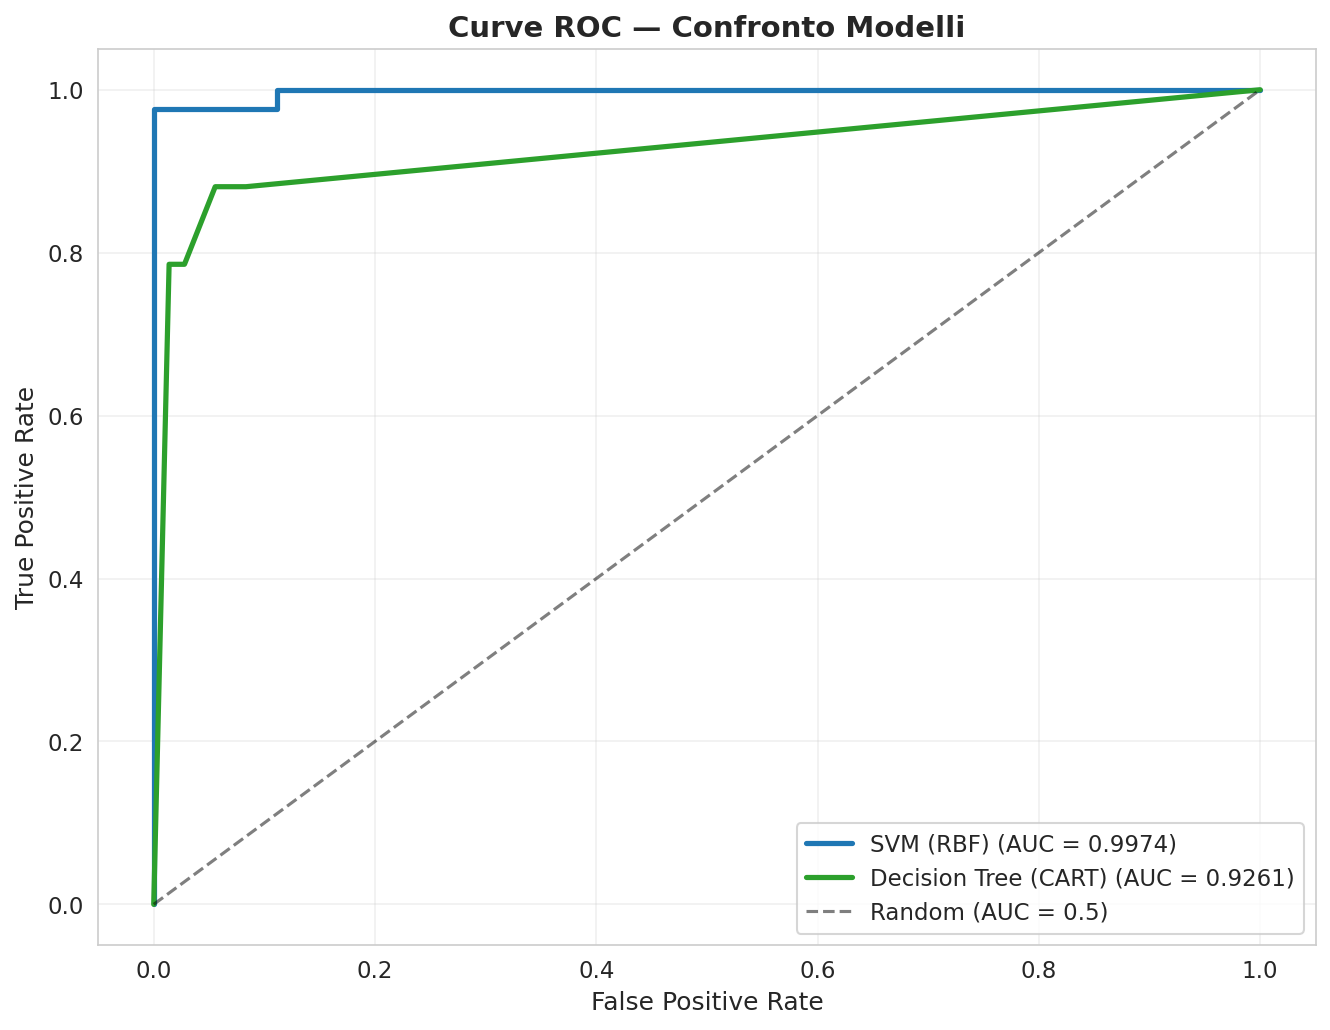

In [60]:
fig, ax = plt.subplots(figsize=(9, 7))
colors_roc = ['#1f77b4', '#2ca02c']

for i, (name, preds) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, preds['y_prob'])
    auc_score = roc_auc_score(y_test, preds['y_prob'])
    ax.plot(fpr, tpr,
            label=f'{name} (AUC = {auc_score:.4f})',
            linewidth=2.5,
            color=colors_roc[i])

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curve ROC — Confronto Modelli', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 5.3 Feature Importance

Pruning: ccp_alpha=0.0, profondità effettiva=7
11 feature usate su 30 totali


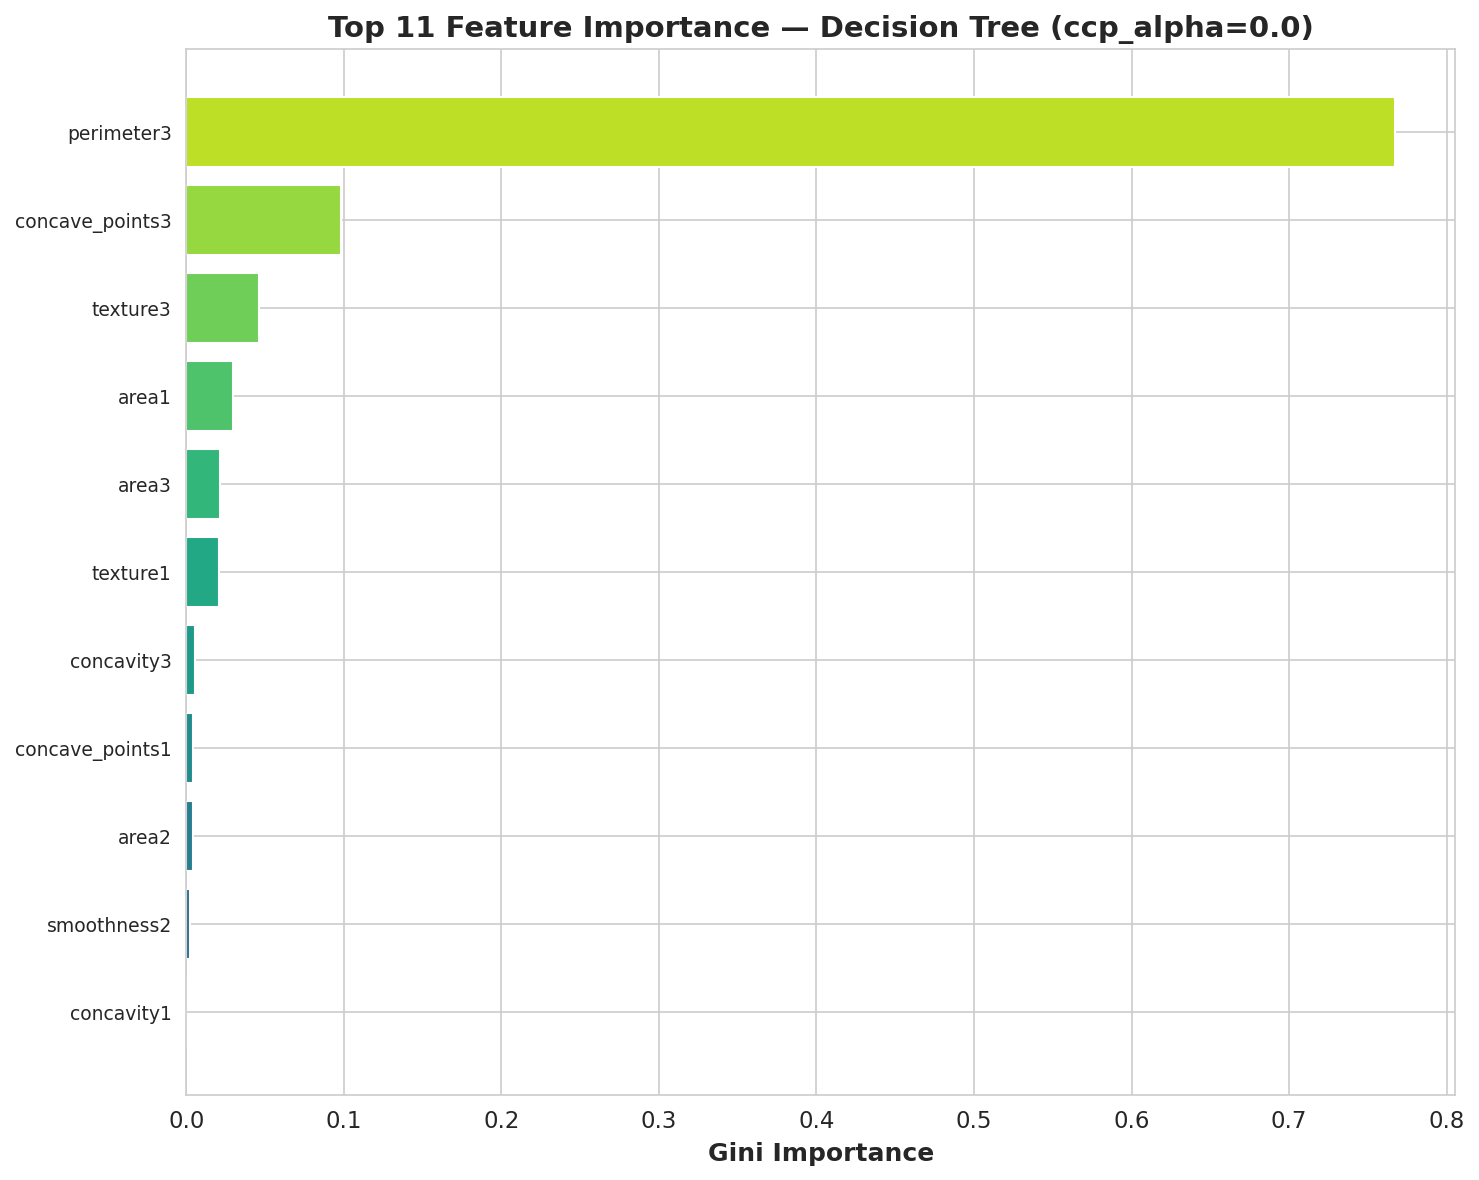

In [61]:
dt_model = best_models['Decision Tree (CART)']
dt_clf = dt_model.named_steps['classifier']

fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_clf.feature_importances_
}).sort_values('Importance', ascending=False)

fi_nonzero = fi_df[fi_df['Importance'] > 0]
print(f'Pruning: ccp_alpha={dt_clf.ccp_alpha}, profondità effettiva={dt_clf.get_depth()}')
print(f'{len(fi_nonzero)} feature usate su {len(X.columns)} totali')

fig, ax = plt.subplots(figsize=(10, 8))
fi_top = fi_df.head(len(fi_nonzero)).sort_values('Importance')
ax.barh(range(len(fi_top)), fi_top['Importance'],
        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(fi_top))))
ax.set_yticks(range(len(fi_top)))
ax.set_yticklabels(fi_top['Feature'], fontsize=9)
ax.set_xlabel('Gini Importance', fontweight='bold')
ax.set_title(f'Top {len(fi_nonzero)} Feature Importance — Decision Tree (ccp_alpha={dt_clf.ccp_alpha})', fontweight='bold')
plt.tight_layout()
plt.show()

### 5.4 Visualizzazione Albero Decisionale

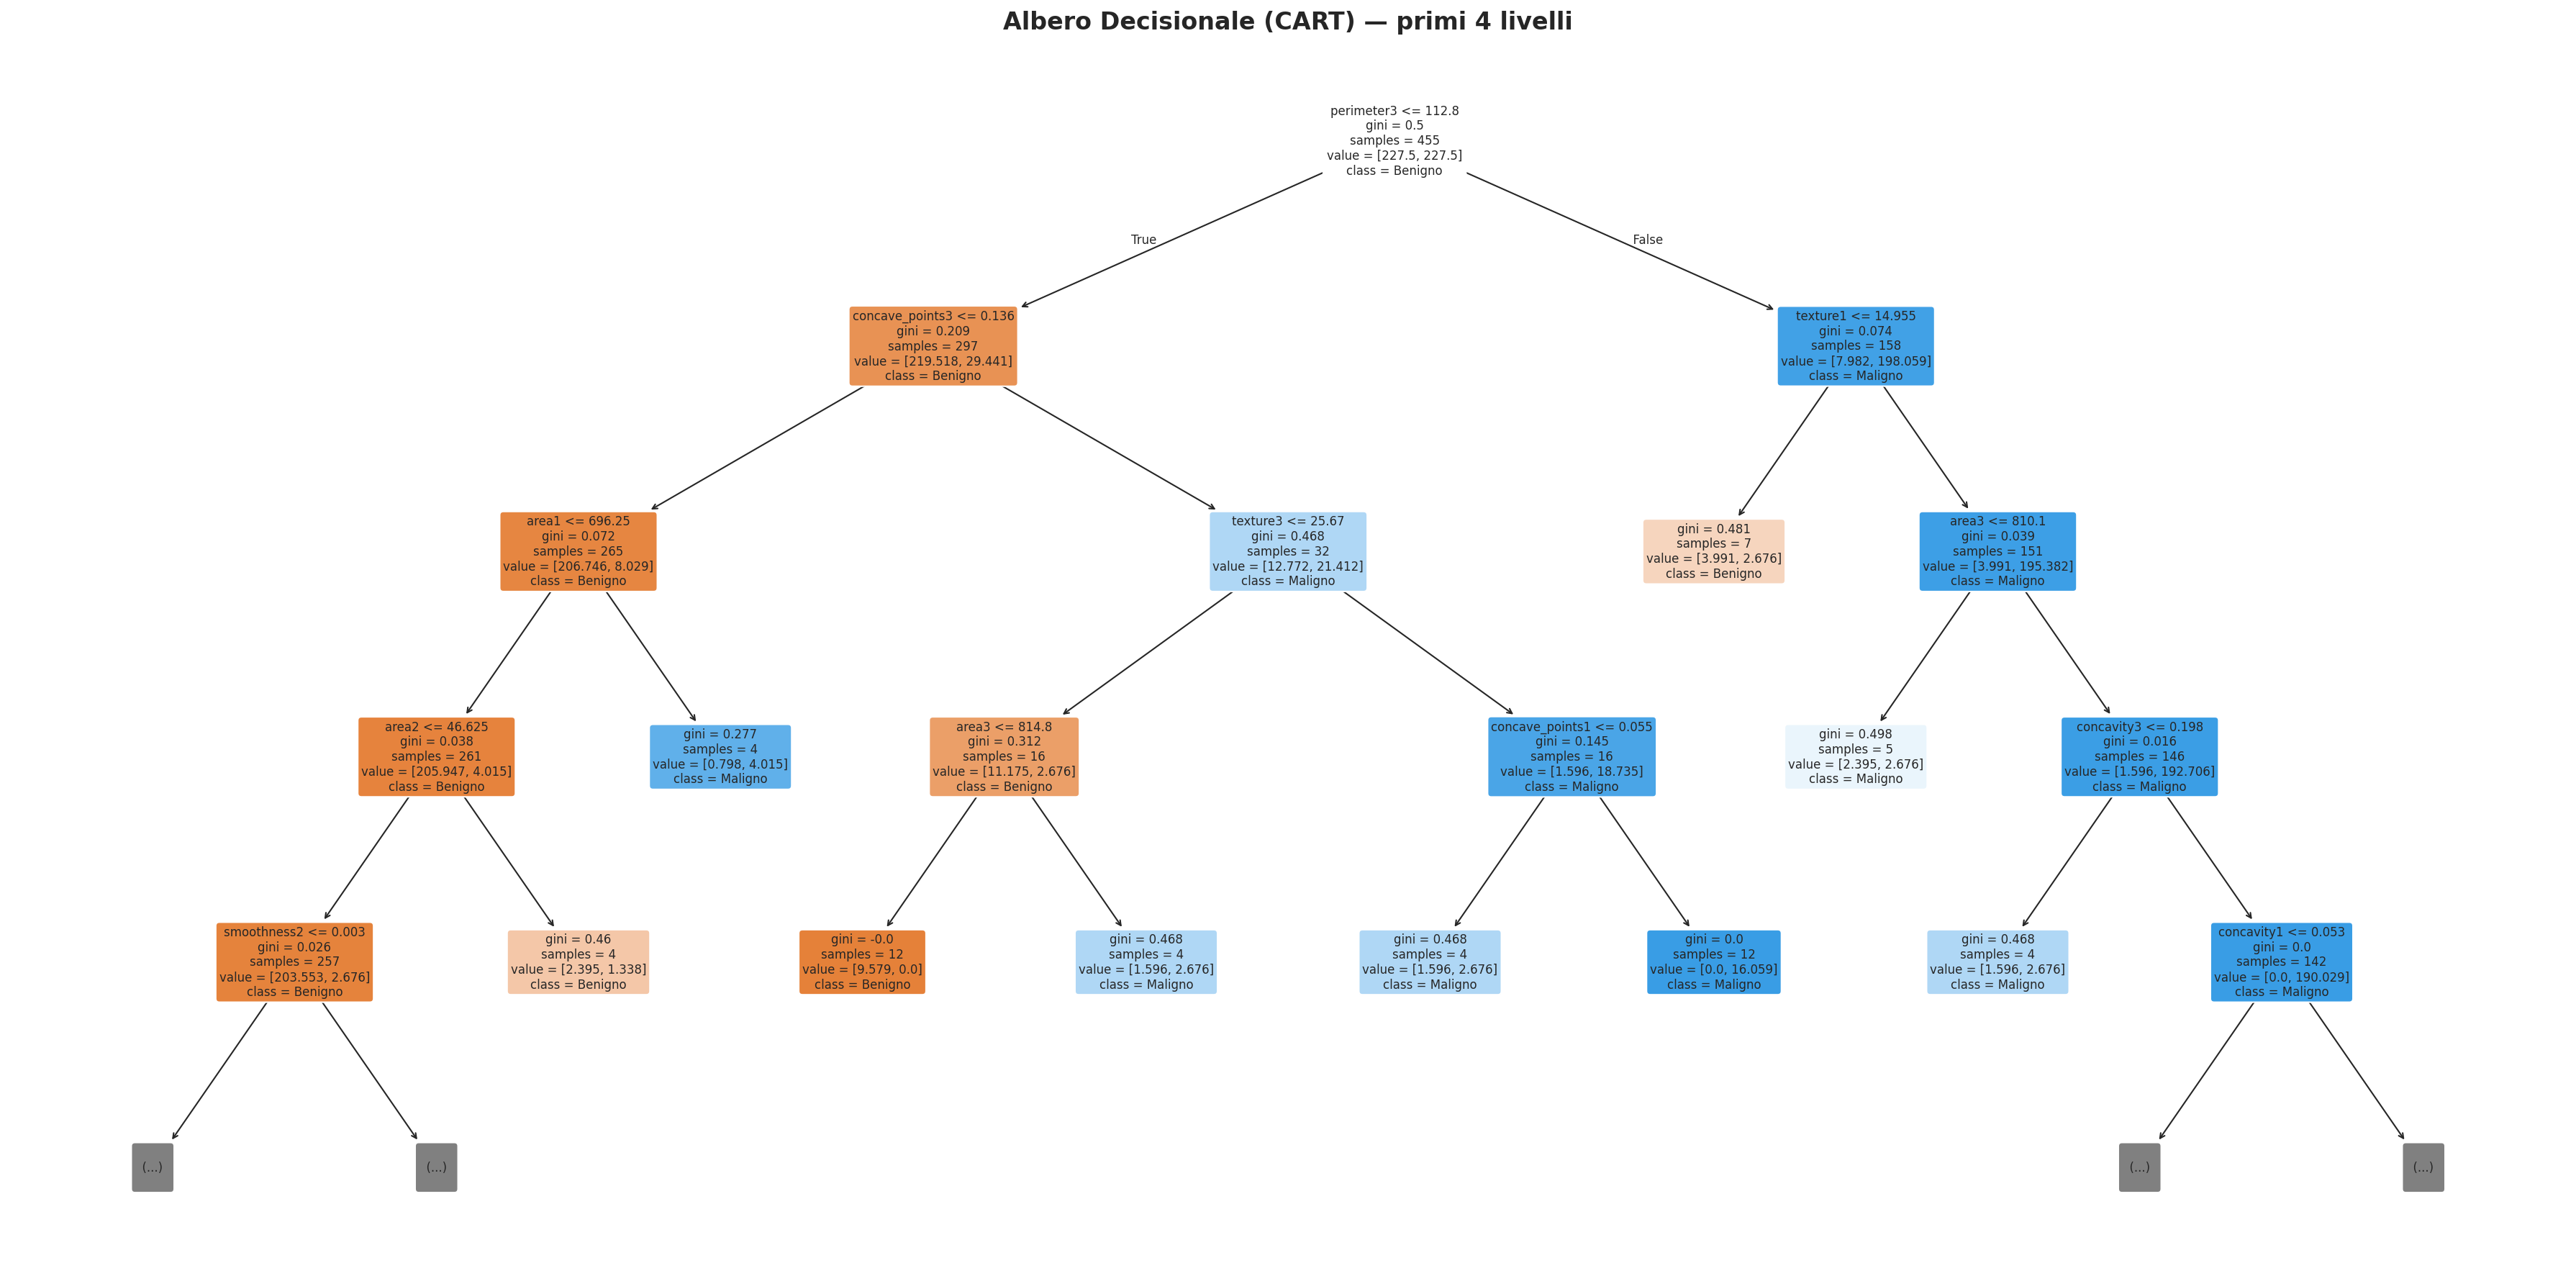

In [62]:
dt_classifier = dt_model.named_steps['classifier']
feat_names = list(X.columns)

fig, ax = plt.subplots(figsize=(24, 12))
plot_tree(
    dt_classifier,
    feature_names=feat_names,
    class_names=['Benigno', 'Maligno'],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4,
    ax=ax
)
ax.set_title('Albero Decisionale (CART) — primi 4 livelli', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

### 5.5 Confronto CV vs Test (Overfitting Check)

In [63]:
cv_tuned_results = {}
for name, model in best_models.items():
    cv_tuned = cross_validate(model, X_train, y_train, cv=cv,
                               scoring=scoring_metrics, n_jobs=-1)
    cv_tuned_results[name] = cv_tuned

rows = []
for i, name in enumerate(pipelines.keys()):
    for metric in scoring_metrics:
        cv_key = f'test_{metric}'
        metric_map = {
            'accuracy': 'Accuracy',
            'precision': 'Precision',
            'recall': 'Recall',
            'f1': 'F1-Score',
            'roc_auc': 'ROC-AUC'
        }

        cv_base_mean = cv_results[name][cv_key].mean()
        cv_base_std = cv_results[name][cv_key].std()
        cv_tuned_mean = cv_tuned_results[name][cv_key].mean()
        cv_tuned_std = cv_tuned_results[name][cv_key].std()
        test_val = results_df[results_df['Modello'] == name][metric_map[metric]].values[0]
        delta = test_val - cv_tuned_mean

        rows.append({
            'Modello': name,
            'Metrica': metric,
            'CV baseline (default)': f"{cv_base_mean:.4f} ± {cv_base_std:.4f}",
            'CV tuned': f"{cv_tuned_mean:.4f} ± {cv_tuned_std:.4f}",
            'Test (tuned)': f"{test_val:.4f}",
            'Δ CV_tuned→Test': f"{delta:+.4f}",
        })

comparison_df = pd.DataFrame(rows)

svm_df = comparison_df[comparison_df['Modello'] == 'SVM (RBF)'].drop(columns='Modello')
dt_df = comparison_df[comparison_df['Modello'] == 'Decision Tree (CART)'].drop(columns='Modello')

print("SVM (RBF)")
display(svm_df.style.hide())
print("\nDecision Tree (CART)")
display(dt_df.style.hide())

SVM (RBF)



Decision Tree (CART)


### 5.6 Tabella Riassuntiva Finale

In [64]:
final_rows = []
for i, name in enumerate(pipelines.keys()):
    final_rows.append({
        'Modello': name,
        'CV F1 (tuned)': f"{cv_tuned_results[name]['test_f1'].mean():.4f} ± {cv_tuned_results[name]['test_f1'].std():.4f}",
        'CV Recall (tuned)': f"{cv_tuned_results[name]['test_recall'].mean():.4f} ± {cv_tuned_results[name]['test_recall'].std():.4f}",
        'Test F1': f"{results_df.iloc[i]['F1-Score']:.4f}",
        'Test Recall': f"{results_df.iloc[i]['Recall']:.4f}",
        'Test ROC-AUC': f"{results_df.iloc[i]['ROC-AUC']:.4f}",
    })

display(pd.DataFrame(final_rows))

Modello    CV F1 (tuned) CV Recall (tuned) Test F1  \
0             SVM (RBF)  0.9674 ± 0.0362   0.9647 ± 0.0471  0.9880   
1  Decision Tree (CART)  0.9268 ± 0.0445   0.9353 ± 0.0614  0.8750   

  Test Recall Test ROC-AUC  
0      0.9762       0.9974  
1      0.8333       0.9261